# Preparação de Dados e Análise Econométrica

**Objetivo:** Ler dados de um Google Sheets, criar variáveis dummies para todas as variáveis de controle, 
preservar consistência entre variáveis dependentes e independentes, e executar regressões com modelo logit ordenado.


## 1. Importando bibliotecas necessárias

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
import seaborn as sns
import re
import textwrap

In [11]:
url = 'https://docs.google.com/spreadsheets/d/1kn6u7jnv-ktwiY0TMYxYWnQhr54dWOYSOYvrqf9W3WY/export?format=csv'
df = pd.read_csv(url)

# Visualização inicial
df.head()

,Carimbo de data/hora,"Ao clicar em ""Aceito"", você declara que compreendeu as informações e consente em participar.",Qual seu nível de formação em Ciências Econômicas?,Você é homem?,Com qual grupo racial/étnico você mais se identifica?,Qual seu nível de escolaridade?,Qual é a sua faixa etária?,Em qual região do Brasil você reside?,Qual é o seu vínculo empregatício?,"Você trabalha com economia, finanças, contabilidade ou áreas correlatas?",...,O governo atual sabe lidar com crises econômicas,O governo deve intervir para controlar preços,A entrada de estrangeiros no mercado de trabalho é benéfica,A indústria nacional deve ser protegida,O Brasil tem chance de virar potência econômica,Lucros empresariais ocorrem às custas dos trabalhadores,A competição entre empresas beneficia consumidores,O Brasil deveria priorizar a produção interna mesmo com preços maiores,A automação prejudica o mercado de trabalho,O Brasil deveria adotar política de livre comércio com outros países
0,01/08/2025 09:24:09,Aceito participar,Não tenho formação em Economia,Sim,Branco,Ensino Superior Completo,19 a 25 anos,Sul,Empregado com carteira assinada (CLT),Sim,...,(0) Discorda,(1) Parcialmente concorda,(2) Concorda,(1) Parcialmente concorda,(2) Concorda,(1) Parcialmente concorda,(2) Concorda,(0) Discorda,(2) Concorda,(2) Concorda
1,01/08/2025 09:30:26,Aceito participar,Graduação em Economia,Não,Branco,Ensino Superior Incompleto,19 a 25 anos,Sul,Estudante,Não,...,(0) Discorda,(0) Discorda,(1) Parcialmente concorda,(2) Concorda,(2) Concorda,(2) Concorda,(2) Concorda,(1) Parcialmente concorda,(1) Parcialmente concorda,(2) Concorda
2,01/08/2025 09:32:26,Aceito participar,Não tenho formação em Economia,Sim,Branco,Ensino Superior Incompleto,19 a 25 anos,Sul,Empregado sem carteira assinada,Não,...,(0) Discorda,(1) Parcialmente concorda,(2) Concorda,(2) Concorda,(0) Discorda,(0) Discorda,(2) Concorda,(1) Parcialmente concorda,(2) Concorda,(2) Concorda
3,01/08/2025 09:33:14,Aceito participar,Não tenho formação em Economia,Sim,Negro,Ensino Superior Completo,26 a 35 anos,Sudeste,Empregado com carteira assinada (CLT),Não,...,(2) Concorda,(2) Concorda,(2) Concorda,(2) Concorda,(2) Concorda,(2) Concorda,(1) Parcialmente concorda,(2) Concorda,(2) Concorda,(1) Parcialmente concorda
4,01/08/2025 09:39:04,Aceito participar,Não tenho formação em Economia,Sim,Branco,Ensino Superior Completo,26 a 35 anos,Sul,Empregado com carteira assinada (CLT),Não,...,(0) Discorda,(0) Discorda,(2) Concorda,(1) Parcialmente concorda,(2) Concorda,(1) Parcialmente concorda,(2) Concorda,(1) Parcialmente concorda,(1) Parcialmente concorda,(1) Parcialmente concorda


In [12]:
# lista de todas as colunas
colunas = df.columns.tolist()

colunas

['Carimbo de data/hora',
 'Ao clicar em "Aceito", você declara que compreendeu as informações e consente em participar.',
 'Qual seu nível de formação em Ciências Econômicas? ',
 'Você é homem? ',
 'Com qual grupo racial/étnico você mais se identifica? ',
 'Qual seu nível de escolaridade? ',
 'Qual é a sua faixa etária? ',
 'Em qual região do Brasil você reside? ',
 'Qual é o seu vínculo empregatício? ',
 'Você trabalha com economia, finanças, contabilidade ou áreas correlatas? ',
 'Você trabalha com política ou áreas correlatas? ',
 'Você se considera uma pessoa politicamente engajada? ',
 'Você costuma acompanhar notícias sobre economia e política? ',
 'Com qual espectro político você mais se identifica? ',
 'Os impostos são muito altos',
 'O déficit federal é grande demais (Dívida pública)',
 'O gasto com ajuda externa é alto demais',
 'Temos imigrantes demais',
 'Há deduções demais para as empresas (Impostos)',
 'A educação e a qualificação profissional são inadequadas',
 'A seguri

In [13]:
# retirando algumas colunas que não serão usadas
# df = df.drop(columns=['Você costuma acompanhar notícias sobre economia e política? ', 'Você trabalha com política ou áreas correlatas? ', 'Você trabalha com economia, finanças, contabilidade ou áreas correlatas? '])

## 3. Tratamento das variáveis

**O que faremos:**  
- Evitar codificação manual das variáveis de controle.  
- Transformar todas as variáveis categóricas de controle em *dummies* automaticamente.  
- Manter colunas numéricas como estão.

In [14]:
# Pergunta original da formação (NUNCA dummificar)
form_econ_col = 'Qual seu nível de formação em Ciências Econômicas? '

# `econ`: 1 se tem qualquer formação em Economia; 0 caso contrário
econ_map = {
    'Não tenho formação em Economia': 0,
    'Graduação em Economia': 0,
    'Mestrado em Economia': 1,
    'Doutorado em Economia': 1
}
econ_series = df[form_econ_col].map(econ_map).astype('Int64')

clt_map = {
    'Empregado com carteira assinada (CLT)': 1,
    'Empregado sem carteira assinada': 0,
    'Autônomo': 2,
    'Empresário': 3,
    'Desempregado': -1,
    'Estudante': -2,
    'Aposentado': -3,
    'Servidor público': -4,
    'Outro': 4
}
df['Qual é o seu vínculo empregatício? '] = df['Qual é o seu vínculo empregatício? '].map(clt_map).astype('Int64')

ideol_map = {
    'Extrema esquerda': -2,
    'Esquerda': -1,
    'Centro': 0,
    'Direita': 1,
    'Extrema direita': 2,
    'Independente': 3,
    'Sem opinião': 0
}
df['Com qual espectro político você mais se identifica? '] = df['Com qual espectro político você mais se identifica? '].map(ideol_map).astype('Int64')

# Demais controles (EXCLUINDO a pergunta de formação)
variaveis_controle = [
    form_econ_col,
    'Você é homem? ',
    'Com qual grupo racial/étnico você mais se identifica? ',
    'Qual seu nível de escolaridade? ',
    'Qual é a sua faixa etária? ',
    # 'Em qual região do Brasil você reside? ',
    'Qual é o seu vínculo empregatício? ',
    # 'Você trabalha com economia, finanças, contabilidade ou áreas correlatas? ',
    # 'Você trabalha com política ou áreas correlatas? ',
    'Você se considera uma pessoa politicamente engajada? ',
    # 'Você costuma acompanhar notícias sobre economia e política? ',
    'Com qual espectro político você mais se identifica? '
]

ctrl_sem_form_econ = [c for c in variaveis_controle if c != form_econ_col]
df_controle = df[ctrl_sem_form_econ].copy()

# Dummies (dtype=float para não virar object)
df_controle_dummies = pd.get_dummies(df_controle, drop_first=True, dtype=float)

# Adiciona `econ` e as colunas numéricas
df_controle_dummies['econ'] = econ_series.astype(float)
df_controle_dummies['Com qual espectro político você mais se identifica? '] = df['Com qual espectro político você mais se identifica? '].astype(float)
df_controle_dummies['Qual é o seu vínculo empregatício? '] = df['Qual é o seu vínculo empregatício? '].astype(float)

# Colunas de controle finais
control_cols = df_controle_dummies.columns.tolist()

# Sanidade
assert form_econ_col not in df_controle_dummies.columns, "form_econ entrou por engano!"
assert 'econ' in control_cols, "econ ficou de fora de control_cols!"

In [15]:
# vamos retirar umas respostas por teste
# retirando quando a pessoa for econ e o espectro for -4 ou -2

# df = df[~((econ_series == 1) & ((df['Com qual espectro político você mais se identifica? '] == -1) | (df['Com qual espectro político você mais se identifica? '] == -2)))]

## 4. Tratamento das variáveis dependentes

Vamos identificar todas as perguntas (variáveis dependentes) que não são de controle e criar versão numérica.


In [16]:
def detect_number(x):
    """Extrai o menor dígito presente (ex.: '1 - discordo' -> 1)."""
    if pd.isna(x):
        return np.nan
    m = re.findall(r'[0-9]', str(x))
    return min(map(int, m)) if m else np.nan

colunas_excluidas = [
    'Carimbo de data/hora',
    'Ao clicar em "Aceito", você declara que compreendeu as informações e consente em participar.'
] + variaveis_controle

df_dependentes = df.drop(columns=colunas_excluidas).apply(lambda s: s.apply(detect_number)).astype('Int64')


# Função para criar acrônimos a partir dos nomes das colunas
# essa função também deve colocar o acronimo criado como chave do dicionário e a pergunta completa como valor
def make_acronym(colname):
    col = re.sub(r'[^\w\s]', ' ', colname, flags=re.UNICODE)
    stop = {'de','da','do','das','dos','a','o','as','os','em','na','no','nas','nos',
            'para','por','com','ao','à','às','e','ou','que','se','é','uma','você',
            'qual','sua','são','sobre','tem'}
    toks = [t.lower() for t in col.split() if t.lower() not in stop]
    return '_'.join(toks[:3]) if len(toks) >= 2 else (toks[0] if toks else col.lower())

acronimos = {make_acronym(c): c for c in df_dependentes.columns}

rename_dep = {c: make_acronym(c) for c in df_dependentes.columns}
df_dependentes.rename(columns=rename_dep, inplace=True)
dependentes_cols = df_dependentes.columns.tolist()

In [17]:
acronimos

{'região_brasil_reside': 'Em qual região do Brasil você reside? ',
 'trabalha_economia_finanças': 'Você trabalha com economia, finanças, contabilidade ou áreas correlatas? ',
 'trabalha_política_áreas': 'Você trabalha com política ou áreas correlatas? ',
 'costuma_acompanhar_notícias': 'Você costuma acompanhar notícias sobre economia e política? ',
 'impostos_muito_altos': 'Os impostos são muito altos',
 'déficit_federal_grande': 'O déficit federal é grande demais (Dívida pública)',
 'gasto_ajuda_externa': 'O gasto com ajuda externa é alto demais',
 'temos_imigrantes_demais': 'Temos imigrantes demais',
 'há_deduções_demais': 'Há deduções demais para as empresas (Impostos)',
 'educação_qualificação_profissional': 'A educação e a qualificação profissional são inadequadas',
 'seguridade_social_previdência': 'A seguridade social (Previdência) atende pessoas demais',
 'mulheres_minorias_têm': 'Mulheres e minorias têm vantagens demais por causa das ações afirmativas (cotas)',
 'pessoas_não_d

In [9]:
# invertendo o dicionário para facilitar a busca
acronimos = {v: k for k, v in acronimos.items()}
acronimos

{'Em qual região do Brasil você reside? ': 'região_brasil_reside',
 'Você trabalha com economia, finanças, contabilidade ou áreas correlatas? ': 'trabalha_economia_finanças',
 'Você trabalha com política ou áreas correlatas? ': 'trabalha_política_áreas',
 'Você costuma acompanhar notícias sobre economia e política? ': 'costuma_acompanhar_notícias',
 'Os impostos são muito altos': 'impostos_muito_altos',
 'O déficit federal é grande demais (Dívida pública)': 'déficit_federal_grande',
 'O gasto com ajuda externa é alto demais': 'gasto_ajuda_externa',
 'Temos imigrantes demais': 'temos_imigrantes_demais',
 'Há deduções demais para as empresas (Impostos)': 'há_deduções_demais',
 'A educação e a qualificação profissional são inadequadas': 'educação_qualificação_profissional',
 'A seguridade social (Previdência) atende pessoas demais': 'seguridade_social_previdência',
 'Mulheres e minorias têm vantagens demais por causa das ações afirmativas (cotas)': 'mulheres_minorias_têm',
 'As pessoas nã

In [22]:
# consultando o dicionário de acrônimos por uma questão unica como acronimo
# isso é útil para verificar se o acrônimo foi criado corretamente
questao = 'impostos_muito_altos'

print("Acrônimos no dicionário:")
pergunta = acronimos.get(questao, "Questão não encontrada")
print(pergunta)  # Exibe a pergunta completa associada ao acrônimo

Acrônimos no dicionário:
Os impostos são muito altos


## 5. Juntando variáveis de controle e dependentes

In [23]:
# --- 3) DataFrame final só com dependentes + dummies de controle ---
df_final = pd.concat([df_dependentes, df_controle_dummies], axis=1)

## 6. Função de análise (Modelo Logit Ordenado)

**O que faz:**  
- Filtra a variável dependente desejada + controles.  
- Gera modelo logit ordenado.  
- Calcula médias previstas e reais para diferentes públicos.  
- Gera gráfico comparativo.


In [26]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

def analisar_variavel_para_latex(df_all, variavel):
    print(f"\nIniciando análise da variável '{variavel}'")

    # (o que) montar dataset apenas com y + controles
    # (por que) evitar vazamento de outras perguntas para o lado direito
    df_model = pd.concat(
        [df_all[[variavel]], df_all[control_cols]],
        axis=1
    ).dropna()

    # y inteiro (categorias 1..J)
    y = pd.to_numeric(df_model[variavel], errors='coerce').astype(int)
    if y.nunique() < 2:
        print("⚠️  Menos de duas classes na variável dependente após limpeza. Pulando.")
        return

    # X numérico
    X = df_model[control_cols].apply(pd.to_numeric, errors='coerce').astype(float)

    # segurança extra: remove colunas constantes
    nunique = X.nunique()
    const_like = nunique[nunique <= 1].index.tolist()
    if const_like:
        X = X.drop(columns=const_like)
        # se 'econ' virou constante e foi removida, não há como simular contrafactual
        econ_disponivel = 'econ' in X.columns
    else:
        econ_disponivel = 'econ' in X.columns

    # ajusta modelo
    model = OrderedModel(y, X, distr='logit', hasconst=False)
    result = model.fit(method='lbfgs')
    print(result.summary())

    # -----------------------------
    # MÉDIAS OBSERVADAS POR GRUPO (econ=0 vs econ=1)
    # (o que) médias reais das respostas por grupo
    # (por que) comparação direta da distribuição observada
    # -----------------------------
    if econ_disponivel:
        mask_e0 = X['econ'] == 0
        mask_e1 = X['econ'] == 1
        media_publico_geral_obs = df_model.loc[mask_e0, variavel].mean() if mask_e0.any() else np.nan
        media_economistas_obs   = df_model.loc[mask_e1, variavel].mean() if mask_e1.any() else np.nan
    else:
        media_publico_geral_obs = np.nan
        media_economistas_obs   = np.nan

    # -----------------------------
    # CONTRAFACTUAL: ECONOMISTAS COMO SE econ=0
    # (o que) para linhas com econ=1, prever média esperada com econ “virando” 0
    # (por que) isolar o efeito da formação econômica mantendo covariáveis constantes
    # -----------------------------
    media_publico_esclarecido = np.nan
    if econ_disponivel and (X['econ'] == 1).any():
        idx_econ = X['econ'] == 1
        X_cf = X.loc[idx_econ].copy()
        X_cf['econ'] = 0.0  # “desliga” a formação em economia

        # probs por categoria
        probs = result.predict(X_cf)              # shape (n_obs, J)
        J = probs.shape[1]
        valores = np.arange(1, J + 1)            # categorias 1..J
        exp_resp = probs @ valores               # E[Y | X, econ=0]
        media_publico_esclarecido = np.mean(exp_resp)

    # -----------------------------
    # PRINT RESUMO
    # -----------------------------
    print(f"Média observada – Público geral (econ=0): {media_publico_geral_obs:.3f}" if pd.notna(media_publico_geral_obs) else "Média observada – Público geral (econ=0): n/d")
    print(f"Média observada – Economistas (econ=1): {media_economistas_obs:.3f}" if pd.notna(media_economistas_obs) else "Média observada – Economistas (econ=1): n/d")
    print(f"Média contrafactual – Público esclarecido (economistas como econ=0): {media_publico_esclarecido:.3f}" if pd.notna(media_publico_esclarecido) else "Média contrafactual – Público esclarecido: n/d")

    # -----------------------------
    # GRÁFICO (matplotlib puro)
    # -----------------------------
    labels = ['Público (econ=0)', 'Economistas (econ=1)', 'Público esclarecido (CF)']
    valores_plot = [
        media_publico_geral_obs if pd.notna(media_publico_geral_obs) else 0.0,
        media_economistas_obs   if pd.notna(media_economistas_obs)   else 0.0,
        media_publico_esclarecido if pd.notna(media_publico_esclarecido) else 0.0
    ]

    plt.figure(figsize=(7, 4))
    plt.barh(labels, valores_plot)
    titulo = f"Médias observadas e contrafactual – {variavel}"
    plt.title(textwrap.fill(titulo, width=70))
    max_x = max([v for v in valores_plot if not np.isnan(v)] + [2])
    plt.xlim(0, max(2, max_x + 0.5))
    for i, v in enumerate(valores_plot):
        plt.text(v + 0.05, i, f'{v:.2f}', va='center')
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

In [24]:
dependentes_cols = [
    # 'região_brasil_reside',
    # 'trabalha_economia_finanças',
    # 'trabalha_política_áreas',
    # 'costuma_acompanhar_notícias',
    'impostos_muito_altos',
    'déficit_federal_grande',
    'gasto_ajuda_externa',
    'temos_imigrantes_demais',
    'há_deduções_demais',
    'educação_qualificação_profissional',
    'seguridade_social_previdência',
    'mulheres_minorias_têm',
    'pessoas_não_dão',
    'governo_regulamenta_muito',
    'pessoas_não_poupam',
    'empresas_lucram_demais',
    'altos_executivos_ganham',
    'produtividade_está_aumentando',
    'tecnologia_causa_demissões',
    'empresas_estão_enviando',
    'empresas_estão_reduzindo',
    'empresas_não_investem',
    'corte_impostos',
    'mais_mulheres_força',
    'aumento_uso_tecnologia',
    'acordos_comerciais_outros',
    'redução_recente_postos',
    'algumas_pessoas_dizem',
    'acha_acordos_comerciais',
    'quem_considera_maior',
    'acha_preços_combustíveis',
    'acha_presidente_pode',
    'acha_novos_postos',
    'desigualdade_entre_ricos',
    'últimos_20_anos',
    'pensando_apenas_salários',
    'algumas_pessoas_dizem',
    'próximos_cinco_anos',
    'espera_geração_seus',
    'filhos_menos_30',
    'reforma_previdência_necessária',
    'reforma_trabalhista_necessária',
    'reforma_tributária_necessária',
    'privatização_estatais_benéfica',
    'produtos_importados_benéficos',
    'corrupção_principal_causa',
    'taxa_juros_selic',
    'governo_atual_sabe',
    'governo_deve_intervir',
    'entrada_estrangeiros_mercado',
    'indústria_nacional_deve',
    'brasil_chance_virar',
    'lucros_empresariais_ocorrem',
    'competição_entre_empresas',
    'brasil_deveria_priorizar',
    'automação_prejudica_mercado',
    'brasil_deveria_adotar'
    ]

INFO:root:Iniciando análise da variável 'impostos_muito_altos'
INFO:root:Pergunta original: Os impostos são muito altos
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                              OrderedModel Results                              
Dep. Variable:     impostos_muito_altos   Log-Likelihood:                -131.61
Model:                     OrderedModel   AIC:                             305.2
Method:              Maximum Likelihood   BIC:                             371.1
Date:                  Sat, 16 Aug 2025                                         
Time:                          22:42:42                                         
No. Observations:                   170                                         
Df Residuals:                       149                                         
Df Model:                            19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Qual é o se

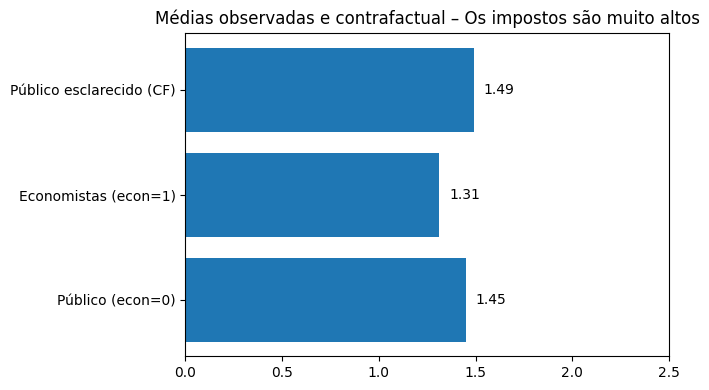

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'déficit_federal_grande'
INFO:root:Pergunta original: O déficit federal é grande demais (Dívida pública)
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                               OrderedModel Results                               
Dep. Variable:     déficit_federal_grande   Log-Likelihood:                -125.09
Model:                       OrderedModel   AIC:                             292.2
Method:                Maximum Likelihood   BIC:                             357.9
Date:                    Sat, 16 Aug 2025                                         
Time:                            22:42:45                                         
No. Observations:                     169                                         
Df Residuals:                         148                                         
Df Model:                              19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------

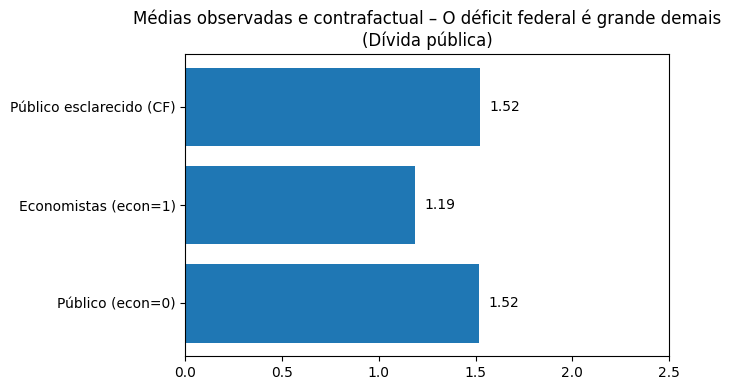

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'gasto_ajuda_externa'
INFO:root:Pergunta original: O gasto com ajuda externa é alto demais
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                              OrderedModel Results                             
Dep. Variable:     gasto_ajuda_externa   Log-Likelihood:                -157.91
Model:                    OrderedModel   AIC:                             357.8
Method:             Maximum Likelihood   BIC:                             423.7
Date:                 Sat, 16 Aug 2025                                         
Time:                         22:42:46                                         
No. Observations:                  170                                         
Df Residuals:                      149                                         
Df Model:                           19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Qual é o seu vínculo

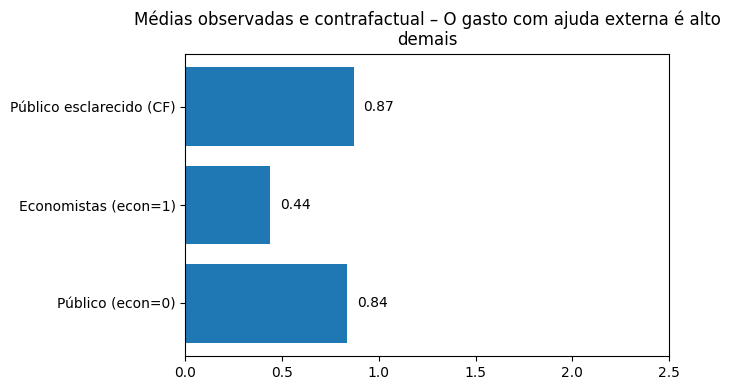

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'temos_imigrantes_demais'
INFO:root:Pergunta original: Temos imigrantes demais
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                                OrderedModel Results                               
Dep. Variable:     temos_imigrantes_demais   Log-Likelihood:                -89.302
Model:                        OrderedModel   AIC:                             220.6
Method:                 Maximum Likelihood   BIC:                             286.5
Date:                     Sat, 16 Aug 2025                                         
Time:                             22:42:47                                         
No. Observations:                      170                                         
Df Residuals:                          149                                         
Df Model:                               19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------

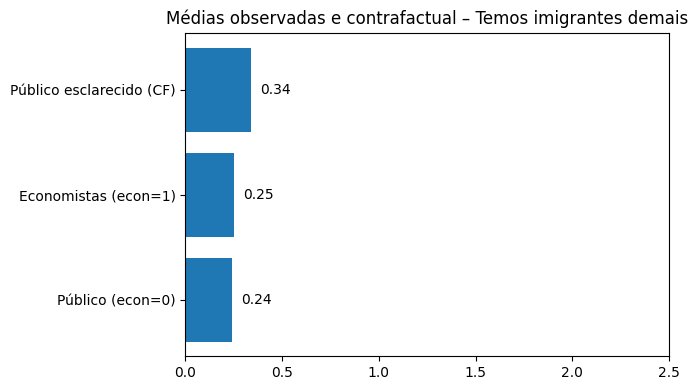

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'há_deduções_demais'
INFO:root:Pergunta original: Há deduções demais para as empresas (Impostos)
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (171, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    155
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                             OrderedModel Results                             
Dep. Variable:     há_deduções_demais   Log-Likelihood:                -169.51
Model:                   OrderedModel   AIC:                             381.0
Method:            Maximum Likelihood   BIC:                             447.0
Date:                Sat, 16 Aug 2025                                         
Time:                        22:42:48                                         
No. Observations:                 171                                         
Df Residuals:                     150                                         
Df Model:                          19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Qual é o seu vínculo empregat

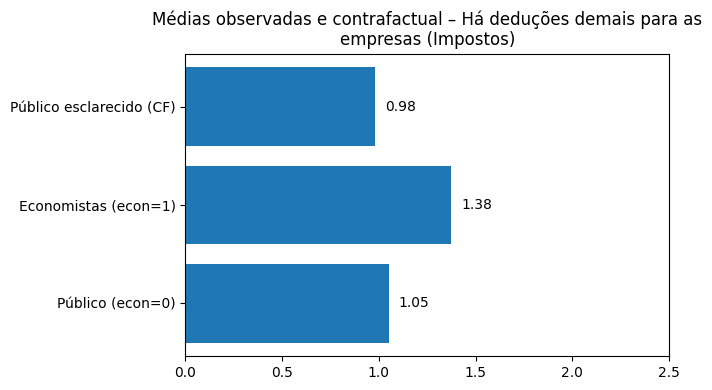

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'educação_qualificação_profissional'
INFO:root:Pergunta original: A educação e a qualificação profissional são inadequadas
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                                     OrderedModel Results                                     
Dep. Variable:     educação_qualificação_profissional   Log-Likelihood:                -136.62
Model:                                   OrderedModel   AIC:                             315.2
Method:                            Maximum Likelihood   BIC:                             381.1
Date:                                Sat, 16 Aug 2025                                         
Time:                                        22:42:51                                         
No. Observations:                                 170                                         
Df Residuals:                                     149                                         
Df Model:                                          19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------

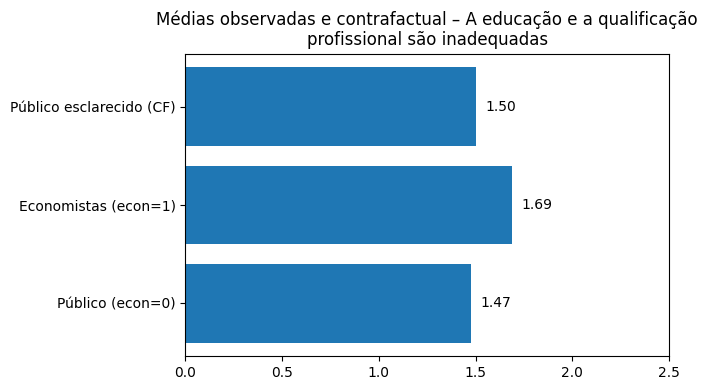

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'seguridade_social_previdência'
INFO:root:Pergunta original: A seguridade social (Previdência) atende pessoas demais
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (171, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    155
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                                   OrderedModel Results                                  
Dep. Variable:     seguridade_social_previdência   Log-Likelihood:                -146.92
Model:                              OrderedModel   AIC:                             335.8
Method:                       Maximum Likelihood   BIC:                             401.8
Date:                           Sat, 16 Aug 2025                                         
Time:                                   22:42:52                                         
No. Observations:                            171                                         
Df Residuals:                                150                                         
Df Model:                                     19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

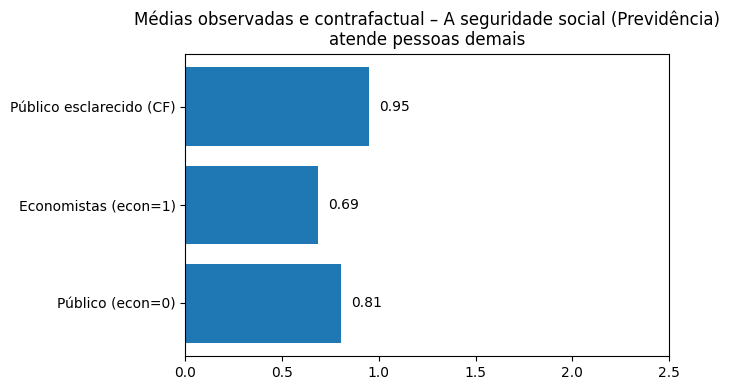

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'mulheres_minorias_têm'
INFO:root:Pergunta original: Mulheres e minorias têm vantagens demais por causa das ações afirmativas (cotas)
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                               OrderedModel Results                              
Dep. Variable:     mulheres_minorias_têm   Log-Likelihood:                -99.126
Model:                      OrderedModel   AIC:                             240.3
Method:               Maximum Likelihood   BIC:                             306.1
Date:                   Sat, 16 Aug 2025                                         
Time:                           22:42:54                                         
No. Observations:                    170                                         
Df Residuals:                        149                                         
Df Model:                             19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Qu

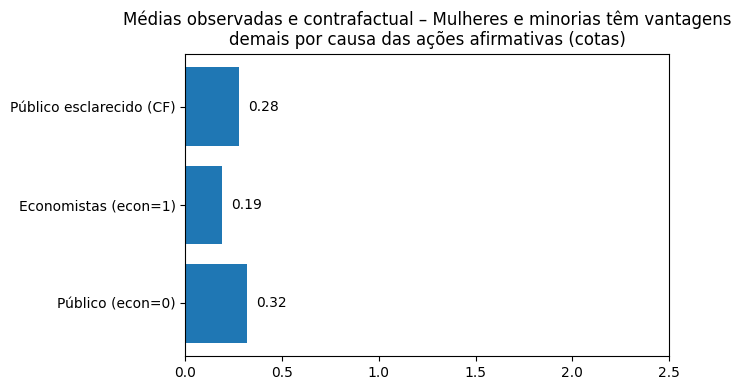

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'pessoas_não_dão'
INFO:root:Pergunta original: As pessoas não dão valor ao trabalho duro
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (171, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    155
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                             OrderedModel Results                             
Dep. Variable:        pessoas_não_dão   Log-Likelihood:                -152.73
Model:                   OrderedModel   AIC:                             347.5
Method:            Maximum Likelihood   BIC:                             413.4
Date:                Sat, 16 Aug 2025                                         
Time:                        22:42:55                                         
No. Observations:                 171                                         
Df Residuals:                     150                                         
Df Model:                          19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Qual é o seu vínculo empregat

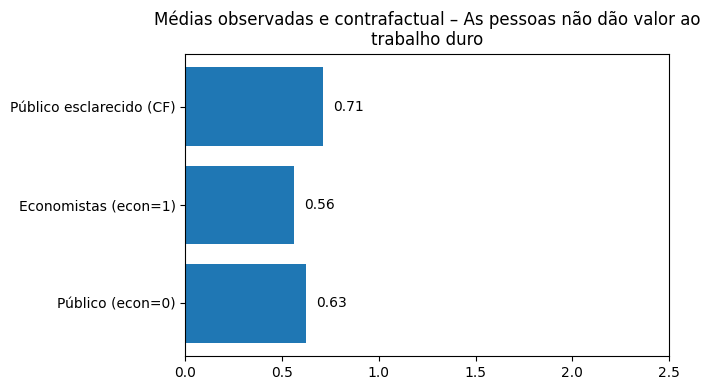

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'governo_regulamenta_muito'
INFO:root:Pergunta original: O governo regulamenta muito os negócios
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (171, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    155
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                                 OrderedModel Results                                
Dep. Variable:     governo_regulamenta_muito   Log-Likelihood:                -140.43
Model:                          OrderedModel   AIC:                             322.9
Method:                   Maximum Likelihood   BIC:                             388.8
Date:                       Sat, 16 Aug 2025                                         
Time:                               22:42:56                                         
No. Observations:                        171                                         
Df Residuals:                            150                                         
Df Model:                                 19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

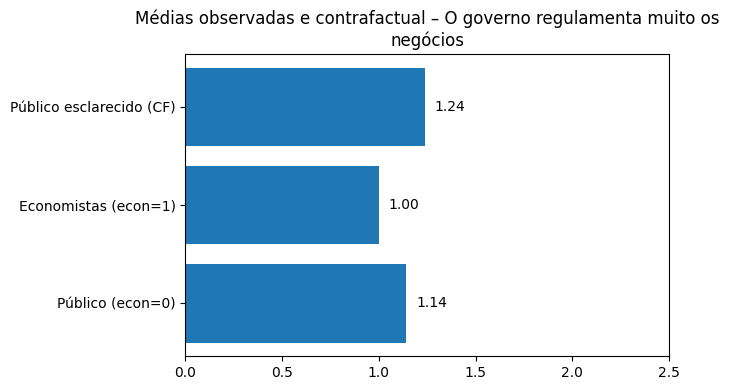

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'pessoas_não_poupam'
INFO:root:Pergunta original: As pessoas não poupam o bastante
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (171, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    155
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                             OrderedModel Results                             
Dep. Variable:     pessoas_não_poupam   Log-Likelihood:                -157.03
Model:                   OrderedModel   AIC:                             356.1
Method:            Maximum Likelihood   BIC:                             422.0
Date:                Sat, 16 Aug 2025                                         
Time:                        22:42:57                                         
No. Observations:                 171                                         
Df Residuals:                     150                                         
Df Model:                          19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Qual é o seu vínculo empregat

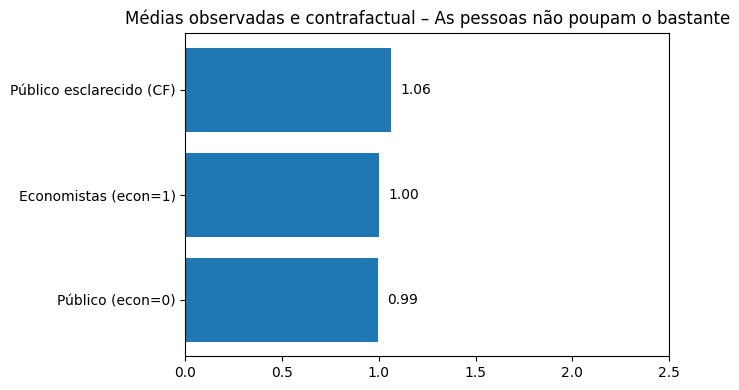

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'empresas_lucram_demais'
INFO:root:Pergunta original: As empresas lucram demais
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                               OrderedModel Results                               
Dep. Variable:     empresas_lucram_demais   Log-Likelihood:                -127.14
Model:                       OrderedModel   AIC:                             296.3
Method:                Maximum Likelihood   BIC:                             362.1
Date:                    Sat, 16 Aug 2025                                         
Time:                            22:42:58                                         
No. Observations:                     170                                         
Df Residuals:                         149                                         
Df Model:                              19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------

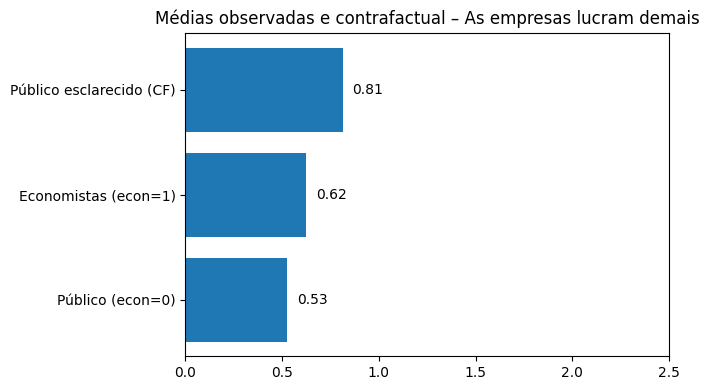

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'altos_executivos_ganham'
INFO:root:Pergunta original: Altos executivos ganham demais
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                                OrderedModel Results                               
Dep. Variable:     altos_executivos_ganham   Log-Likelihood:                -147.74
Model:                        OrderedModel   AIC:                             337.5
Method:                 Maximum Likelihood   BIC:                             403.3
Date:                     Sat, 16 Aug 2025                                         
Time:                             22:42:59                                         
No. Observations:                      170                                         
Df Residuals:                          149                                         
Df Model:                               19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------

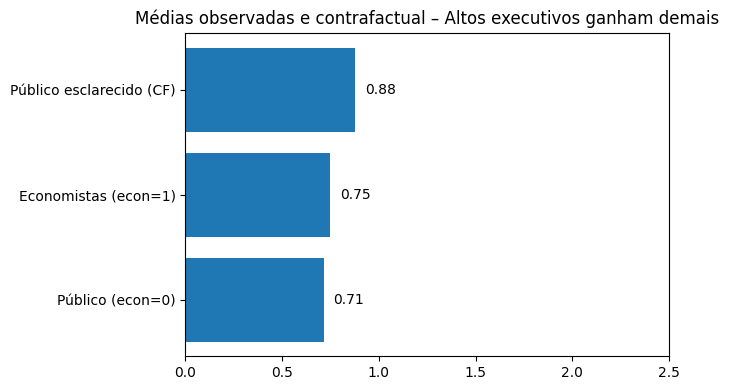

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'produtividade_está_aumentando'
INFO:root:Pergunta original: A produtividade está aumentando devagar demais
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                                   OrderedModel Results                                  
Dep. Variable:     produtividade_está_aumentando   Log-Likelihood:                -158.25
Model:                              OrderedModel   AIC:                             358.5
Method:                       Maximum Likelihood   BIC:                             424.3
Date:                           Sat, 16 Aug 2025                                         
Time:                                   22:43:00                                         
No. Observations:                            170                                         
Df Residuals:                                149                                         
Df Model:                                     19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

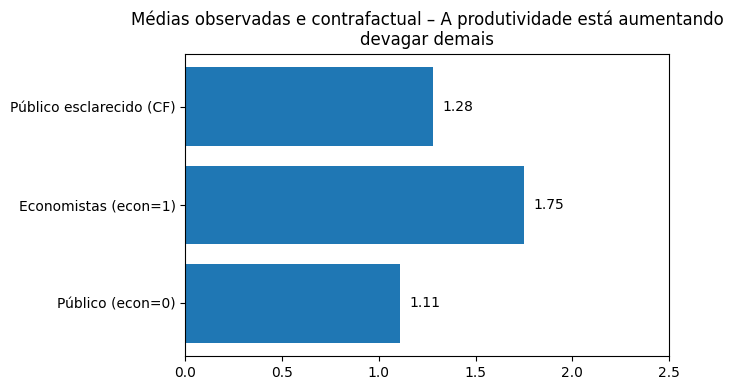

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'tecnologia_causa_demissões'
INFO:root:Pergunta original: A tecnologia causa demissões
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                                 OrderedModel Results                                 
Dep. Variable:     tecnologia_causa_demissões   Log-Likelihood:                -125.83
Model:                           OrderedModel   AIC:                             293.7
Method:                    Maximum Likelihood   BIC:                             359.5
Date:                        Sat, 16 Aug 2025                                         
Time:                                22:43:01                                         
No. Observations:                         170                                         
Df Residuals:                             149                                         
Df Model:                                  19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------

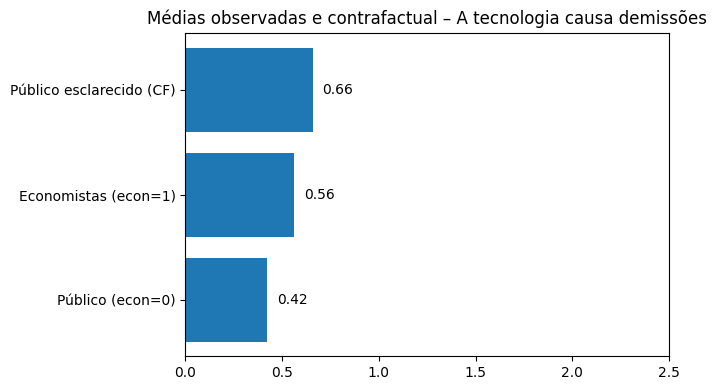

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'empresas_estão_enviando'
INFO:root:Pergunta original: As empresas estão enviando funcionários ao estrangeiro
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (171, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    155
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                                OrderedModel Results                               
Dep. Variable:     empresas_estão_enviando   Log-Likelihood:                -103.08
Model:                        OrderedModel   AIC:                             248.2
Method:                 Maximum Likelihood   BIC:                             314.1
Date:                     Sat, 16 Aug 2025                                         
Time:                             22:43:03                                         
No. Observations:                      171                                         
Df Residuals:                          150                                         
Df Model:                               19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------

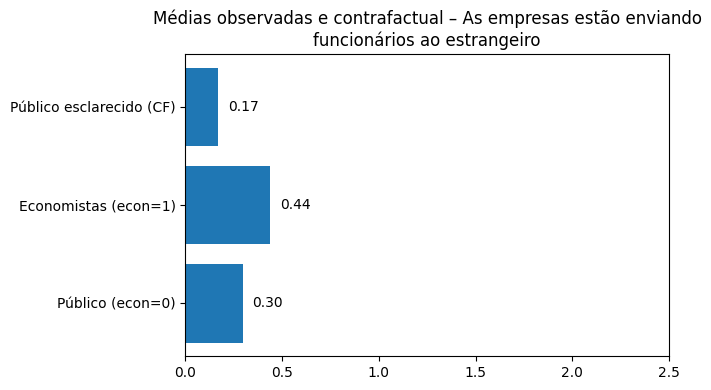

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'empresas_estão_reduzindo'
INFO:root:Pergunta original: As empresas estão reduzindo os postos de trabalho
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (171, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    155
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                                OrderedModel Results                                
Dep. Variable:     empresas_estão_reduzindo   Log-Likelihood:                -153.67
Model:                         OrderedModel   AIC:                             349.3
Method:                  Maximum Likelihood   BIC:                             415.3
Date:                      Sat, 16 Aug 2025                                         
Time:                              22:43:04                                         
No. Observations:                       171                                         
Df Residuals:                           150                                         
Df Model:                                19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------

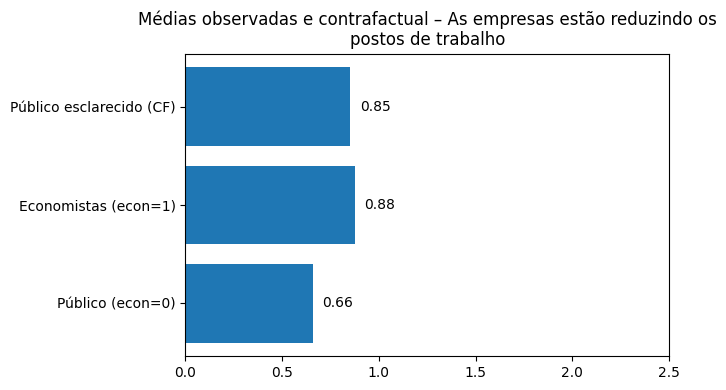

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'empresas_não_investem'
INFO:root:Pergunta original: As empresas não investem o suficiente em educação e qualificação profissional
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                               OrderedModel Results                              
Dep. Variable:     empresas_não_investem   Log-Likelihood:                -164.96
Model:                      OrderedModel   AIC:                             371.9
Method:               Maximum Likelihood   BIC:                             437.8
Date:                   Sat, 16 Aug 2025                                         
Time:                           22:43:05                                         
No. Observations:                    170                                         
Df Residuals:                        149                                         
Df Model:                             19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Qu

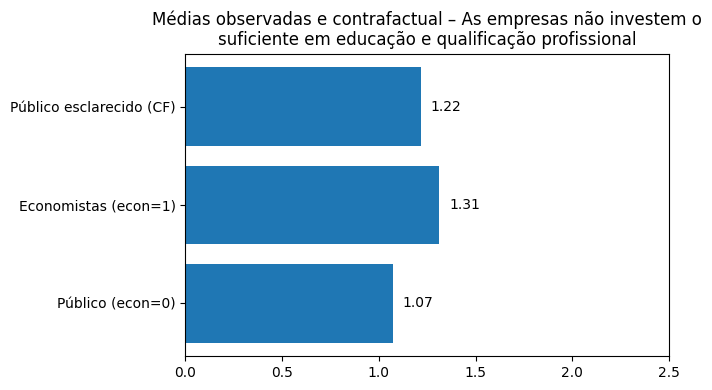

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'corte_impostos'
INFO:root:Pergunta original: Corte de impostos
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (171, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    155
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                             OrderedModel Results                             
Dep. Variable:         corte_impostos   Log-Likelihood:                -91.524
Model:                   OrderedModel   AIC:                             225.0
Method:            Maximum Likelihood   BIC:                             291.0
Date:                Sat, 16 Aug 2025                                         
Time:                        22:43:07                                         
No. Observations:                 171                                         
Df Residuals:                     150                                         
Df Model:                          19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Qual é o seu vínculo empregat

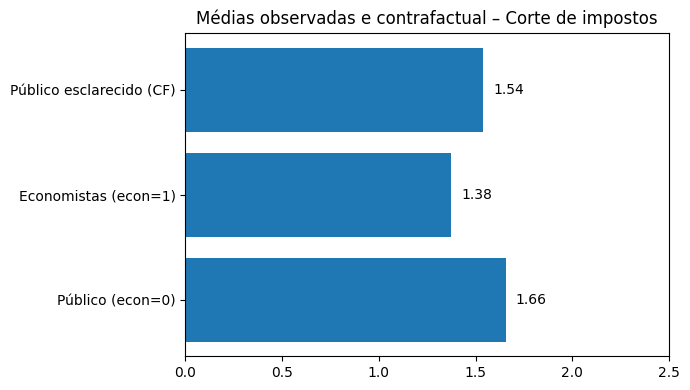

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'mais_mulheres_força'
INFO:root:Pergunta original: Mais mulheres na força de trabalho
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (171, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    155
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                              OrderedModel Results                             
Dep. Variable:     mais_mulheres_força   Log-Likelihood:                -109.53
Model:                    OrderedModel   AIC:                             261.1
Method:             Maximum Likelihood   BIC:                             327.0
Date:                 Sat, 16 Aug 2025                                         
Time:                         22:43:09                                         
No. Observations:                  171                                         
Df Residuals:                      150                                         
Df Model:                           19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Qual é o seu vínculo

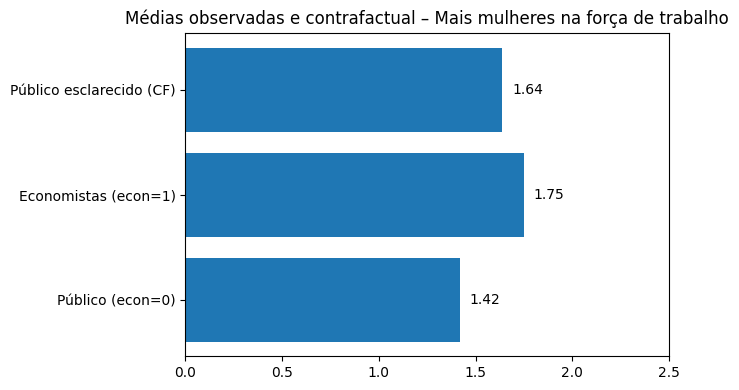

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'aumento_uso_tecnologia'
INFO:root:Pergunta original: Aumento do uso de tecnologia no trabalho
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (171, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    155
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
/home/schadenlord/ubuntu/udesc/tcc_esag/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
INFO:root:Modelo ajustado com sucesso


                               OrderedModel Results                               
Dep. Variable:     aumento_uso_tecnologia   Log-Likelihood:                -13.553
Model:                       OrderedModel   AIC:                             69.11
Method:                Maximum Likelihood   BIC:                             135.1
Date:                    Sat, 16 Aug 2025                                         
Time:                            22:43:10                                         
No. Observations:                     171                                         
Df Residuals:                         150                                         
Df Model:                              19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------

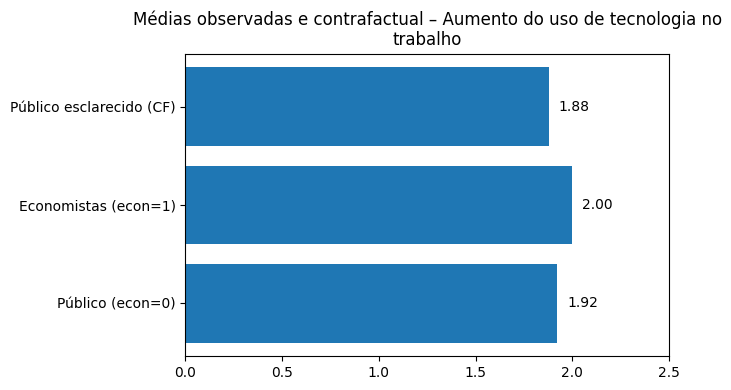

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'acordos_comerciais_outros'
INFO:root:Pergunta original: Acordos comerciais com outros países
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (171, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    155
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
/home/schadenlord/ubuntu/udesc/tcc_esag/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
INFO:root:Modelo ajustado com sucesso


                                 OrderedModel Results                                
Dep. Variable:     acordos_comerciais_outros   Log-Likelihood:                -42.333
Model:                          OrderedModel   AIC:                             126.7
Method:                   Maximum Likelihood   BIC:                             192.6
Date:                       Sat, 16 Aug 2025                                         
Time:                               22:43:11                                         
No. Observations:                        171                                         
Df Residuals:                            150                                         
Df Model:                                 19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

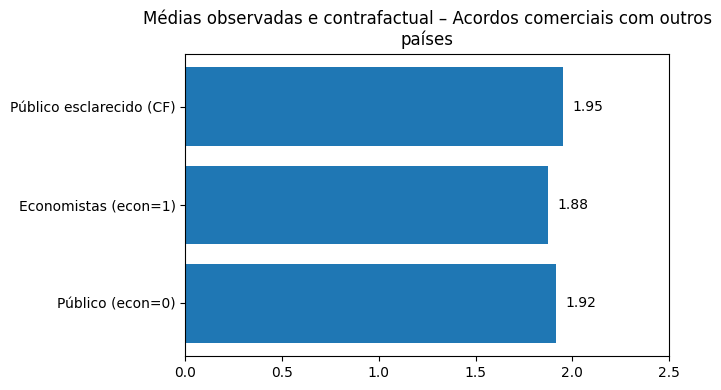

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'redução_recente_postos'
INFO:root:Pergunta original: Redução recente dos postos de trabalho em grandes empresas
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                               OrderedModel Results                               
Dep. Variable:     redução_recente_postos   Log-Likelihood:                -133.79
Model:                       OrderedModel   AIC:                             309.6
Method:                Maximum Likelihood   BIC:                             375.4
Date:                    Sat, 16 Aug 2025                                         
Time:                            22:43:12                                         
No. Observations:                     170                                         
Df Residuals:                         149                                         
Df Model:                              19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------

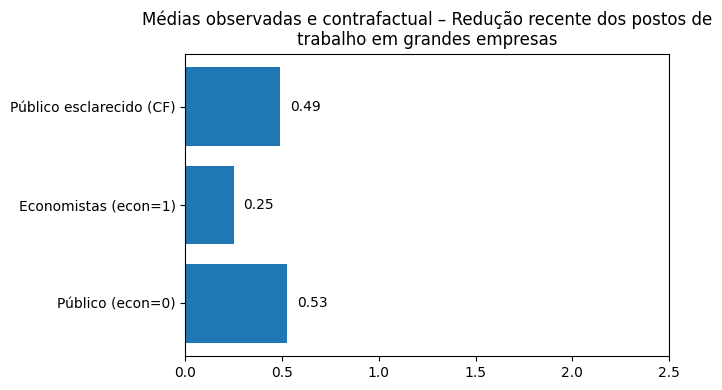

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'algumas_pessoas_dizem'
INFO:root:Pergunta original: Algumas pessoas dizem que, para ter uma vida confortável, a família média deve ter dois assalariados em tempo integral. Você concorda com isso, ou acha que a família média pode viver confortavelmente com apenas um assalariado em tempo integral?
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 21)
ERROR:root:Erro durante a análise: arg must be a list, tuple, 1-d array, or Series
Traceback (most recent call last):
  File "/tmp/ipykernel_12708/873264162.py", line 21, in analisar_variavel_para_latex_log
    y = pd.to_numeric(df_model[variavel], errors='coerce').astype(int)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/schadenlord/ubuntu/udesc/tcc_esag/.venv/lib/python3.12/site-packages/pandas/core/tools/numeric.py", line 209, in to_numeric
    raise TypeError("arg must be a list, tuple, 1-d arr

                                OrderedModel Results                               
Dep. Variable:     acha_acordos_comerciais   Log-Likelihood:                -104.87
Model:                        OrderedModel   AIC:                             251.7
Method:                 Maximum Likelihood   BIC:                             317.5
Date:                     Sat, 16 Aug 2025                                         
Time:                             22:43:13                                         
No. Observations:                      169                                         
Df Residuals:                          148                                         
Df Model:                               19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------

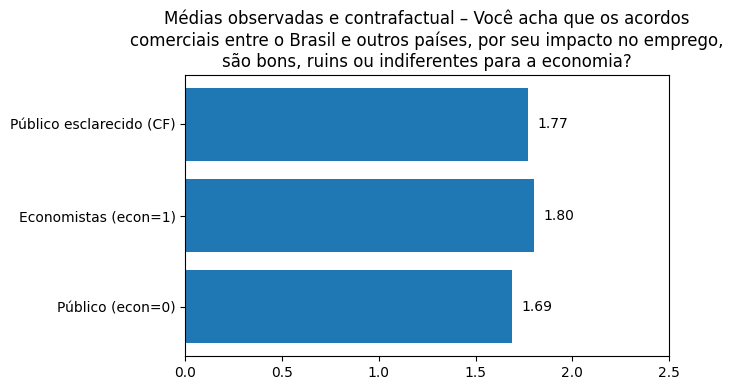

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'quem_considera_maior'
INFO:root:Pergunta original: Quem você considera o maior responsável pelo aumento dos preços dos combustíveis?
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                              OrderedModel Results                              
Dep. Variable:     quem_considera_maior   Log-Likelihood:                -172.71
Model:                     OrderedModel   AIC:                             387.4
Method:              Maximum Likelihood   BIC:                             453.1
Date:                  Sat, 16 Aug 2025                                         
Time:                          22:43:14                                         
No. Observations:                   169                                         
Df Residuals:                       148                                         
Df Model:                            19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Qual é o se

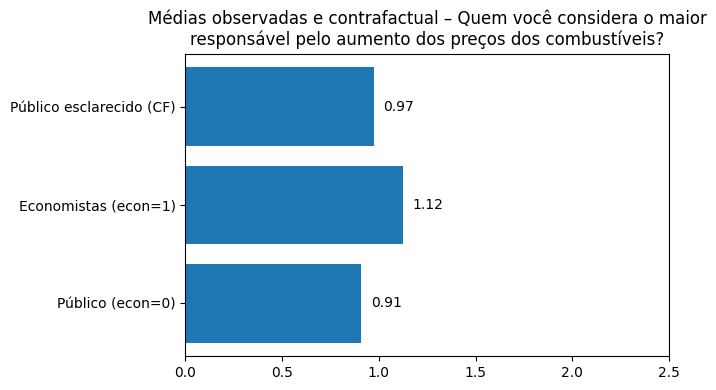

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'acha_preços_combustíveis'
INFO:root:Pergunta original: Você acha que os preços dos combustíveis são altos demais, baixos demais ou no nível certo?
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (171, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    155
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
/home/schadenlord/ubuntu/udesc/tcc_esag/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
INFO:root:Modelo ajustado com sucesso


                                OrderedModel Results                                
Dep. Variable:     acha_preços_combustíveis   Log-Likelihood:                -60.524
Model:                         OrderedModel   AIC:                             163.0
Method:                  Maximum Likelihood   BIC:                             229.0
Date:                      Sat, 16 Aug 2025                                         
Time:                              22:43:15                                         
No. Observations:                       171                                         
Df Residuals:                           150                                         
Df Model:                                19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------

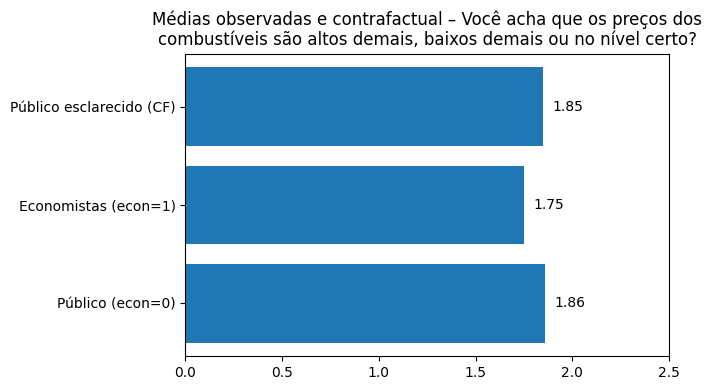

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'acha_presidente_pode'
INFO:root:Pergunta original: Você acha que o presidente pode fazer muito, pouco ou que está além da capacidade de ele melhorar a economia?
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (167, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    152
1.0     15
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                              OrderedModel Results                              
Dep. Variable:     acha_presidente_pode   Log-Likelihood:                -138.78
Model:                     OrderedModel   AIC:                             319.6
Method:              Maximum Likelihood   BIC:                             385.0
Date:                  Sat, 16 Aug 2025                                         
Time:                          22:43:18                                         
No. Observations:                   167                                         
Df Residuals:                       146                                         
Df Model:                            19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Qual é o se

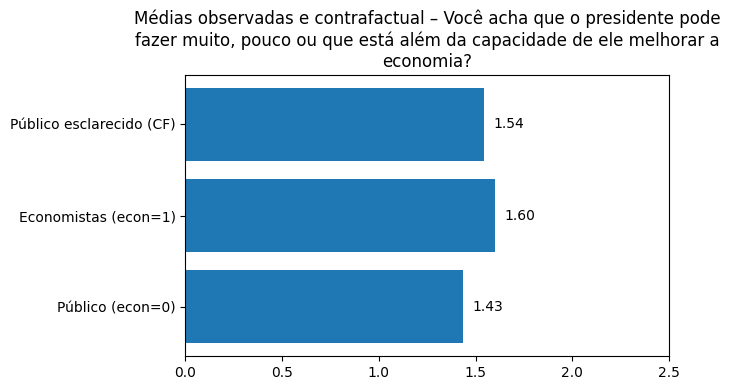

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'acha_novos_postos'
INFO:root:Pergunta original: Você acha que os novos postos de trabalho do país pagam bem ou mal?
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (168, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    152
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                             OrderedModel Results                             
Dep. Variable:      acha_novos_postos   Log-Likelihood:                -112.83
Model:                   OrderedModel   AIC:                             267.7
Method:            Maximum Likelihood   BIC:                             333.3
Date:                Sat, 16 Aug 2025                                         
Time:                        22:43:19                                         
No. Observations:                 168                                         
Df Residuals:                     147                                         
Df Model:                          19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Qual é o seu vínculo empregat

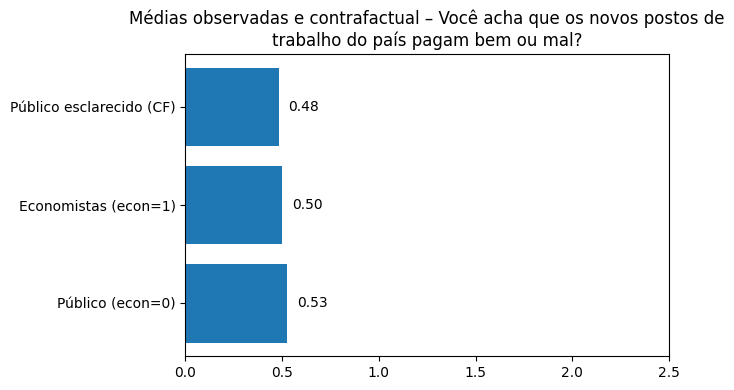

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'desigualdade_entre_ricos'
INFO:root:Pergunta original: A desigualdade entre ricos e pobres, comparada a 20 anos atrás, está:
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                                OrderedModel Results                                
Dep. Variable:     desigualdade_entre_ricos   Log-Likelihood:                -158.11
Model:                         OrderedModel   AIC:                             358.2
Method:                  Maximum Likelihood   BIC:                             424.1
Date:                      Sat, 16 Aug 2025                                         
Time:                              22:43:21                                         
No. Observations:                       170                                         
Df Residuals:                           149                                         
Df Model:                                19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------

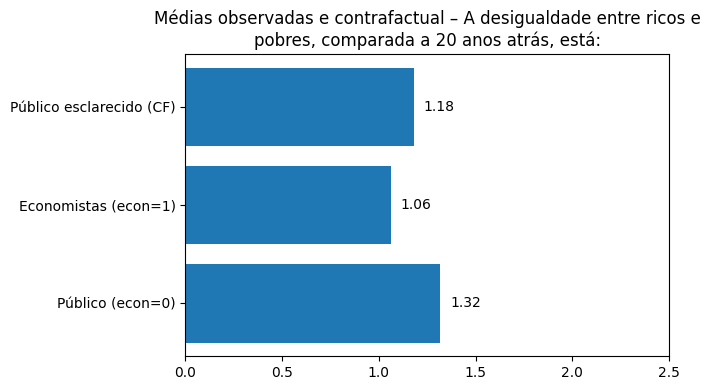

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'últimos_20_anos'
INFO:root:Pergunta original: Nos últimos 20 anos, você acha que, em geral, as rendas familiares dos brasileiros médios têm aumentado mais rapidamente do que o custo de vida, tem se mantido aproximadamente no nível do custo de vida, ou tem ficado atrás do custo de vida?
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                             OrderedModel Results                             
Dep. Variable:        últimos_20_anos   Log-Likelihood:                -144.67
Model:                   OrderedModel   AIC:                             331.3
Method:            Maximum Likelihood   BIC:                             397.1
Date:                Sat, 16 Aug 2025                                         
Time:                        22:43:23                                         
No. Observations:                 169                                         
Df Residuals:                     148                                         
Df Model:                          19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Qual é o seu vínculo empregat

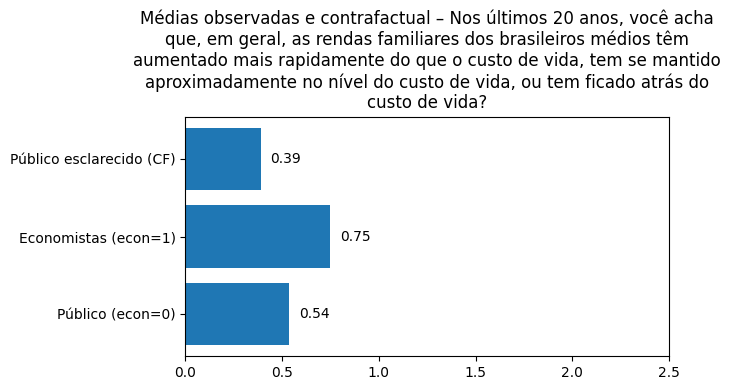

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'pensando_apenas_salários'
INFO:root:Pergunta original: Pensando apenas nos salários do trabalhador brasileiros médio, você acha que, nos últimos 20 anos, eles têm aumentado mais rapidamente do que o custo de vida, têm se mantido aproximadamente no mesmo nível do custo de vida, ou têm ficado atrás do custo de vida?
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (168, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    152
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
/home/schadenlord/ubuntu/udesc/tcc_esag/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
INFO:root:Modelo ajustado com sucesso


                                OrderedModel Results                                
Dep. Variable:     pensando_apenas_salários   Log-Likelihood:                -126.68
Model:                         OrderedModel   AIC:                             295.4
Method:                  Maximum Likelihood   BIC:                             361.0
Date:                      Sat, 16 Aug 2025                                         
Time:                              22:43:24                                         
No. Observations:                       168                                         
Df Residuals:                           147                                         
Df Model:                                19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------

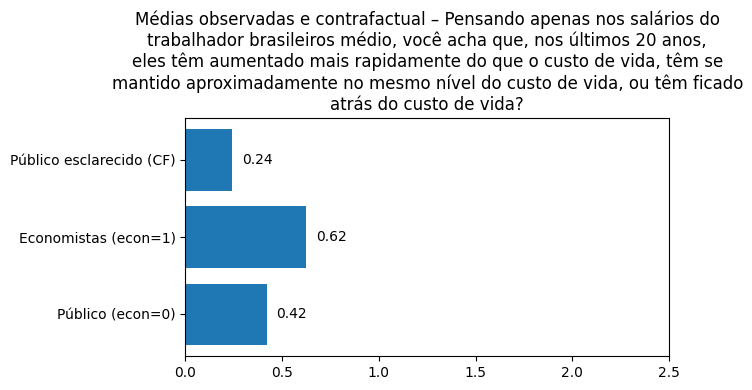

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'algumas_pessoas_dizem'
INFO:root:Pergunta original: Algumas pessoas dizem que, para ter uma vida confortável, a família média deve ter dois assalariados em tempo integral. Você concorda com isso, ou acha que a família média pode viver confortavelmente com apenas um assalariado em tempo integral?
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 21)
ERROR:root:Erro durante a análise: arg must be a list, tuple, 1-d array, or Series
Traceback (most recent call last):
  File "/tmp/ipykernel_12708/873264162.py", line 21, in analisar_variavel_para_latex_log
    y = pd.to_numeric(df_model[variavel], errors='coerce').astype(int)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/schadenlord/ubuntu/udesc/tcc_esag/.venv/lib/python3.12/site-packages/pandas/core/tools/numeric.py", line 209, in to_numeric
    raise TypeError("arg must be a list, tuple, 1-d arr

                              OrderedModel Results                             
Dep. Variable:     próximos_cinco_anos   Log-Likelihood:                -157.54
Model:                    OrderedModel   AIC:                             357.1
Method:             Maximum Likelihood   BIC:                             422.3
Date:                 Sat, 16 Aug 2025                                         
Time:                         22:43:25                                         
No. Observations:                  165                                         
Df Residuals:                      144                                         
Df Model:                           19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Qual é o seu vínculo

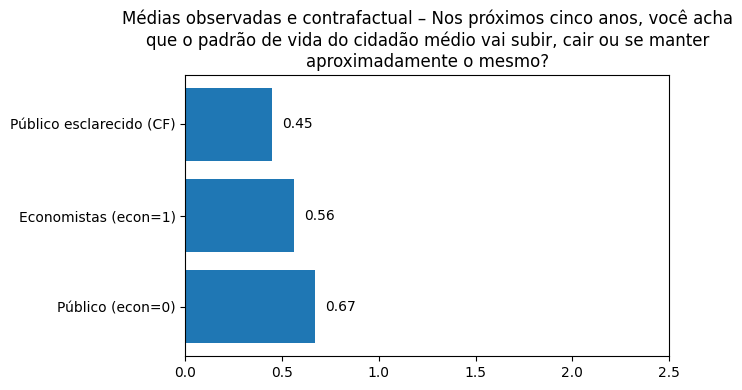

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'espera_geração_seus'
INFO:root:Pergunta original: Você espera que a geração de seus filhos desfrute de um padrão de vida mais alto ou mais baixo do que a sua geração, ou acha que será aproximadamente o mesmo?

INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                              OrderedModel Results                             
Dep. Variable:     espera_geração_seus   Log-Likelihood:                -151.55
Model:                    OrderedModel   AIC:                             345.1
Method:             Maximum Likelihood   BIC:                             410.8
Date:                 Sat, 16 Aug 2025                                         
Time:                         22:43:27                                         
No. Observations:                  169                                         
Df Residuals:                      148                                         
Df Model:                           19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Qual é o seu vínculo

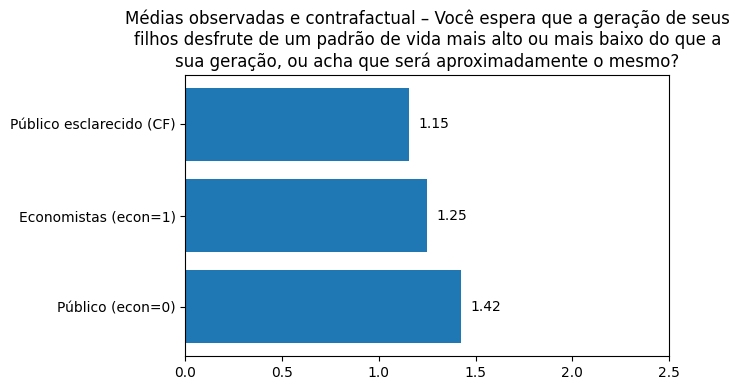

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'filhos_menos_30'
INFO:root:Pergunta original: (Se você tem filhos com menos de 30 anos) Quando eles atingirem a sua idade, você espera que eles desfrutem de um padrão de vida mais alto ou mais baixo do que o seu agora, ou espera que seja aproximadamente o mesmo?

INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (128, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    114
1.0     14
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
/home/schadenlord/ubuntu/udesc/tcc_esag/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
INFO:root:Modelo ajustado com sucesso


                             OrderedModel Results                             
Dep. Variable:        filhos_menos_30   Log-Likelihood:                -96.127
Model:                   OrderedModel   AIC:                             234.3
Method:            Maximum Likelihood   BIC:                             294.1
Date:                Sat, 16 Aug 2025                                         
Time:                        22:43:29                                         
No. Observations:                 128                                         
Df Residuals:                     107                                         
Df Model:                          19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Qual é o seu vínculo empregat

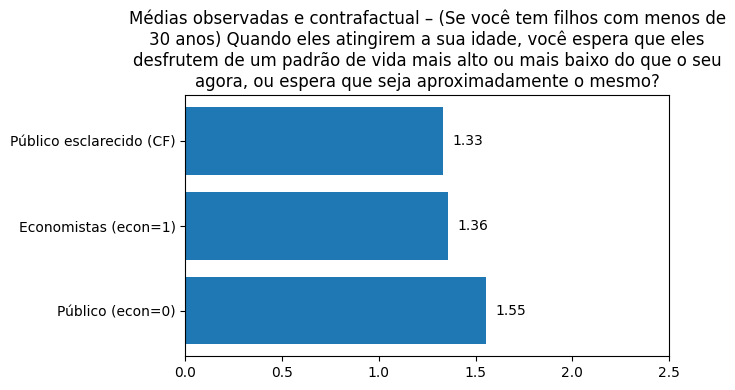

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'reforma_previdência_necessária'
INFO:root:Pergunta original: A reforma da previdência é necessária
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                                   OrderedModel Results                                   
Dep. Variable:     reforma_previdência_necessária   Log-Likelihood:                -132.11
Model:                               OrderedModel   AIC:                             306.2
Method:                        Maximum Likelihood   BIC:                             371.9
Date:                            Sat, 16 Aug 2025                                         
Time:                                    22:43:30                                         
No. Observations:                             169                                         
Df Residuals:                                 148                                         
Df Model:                                      19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------

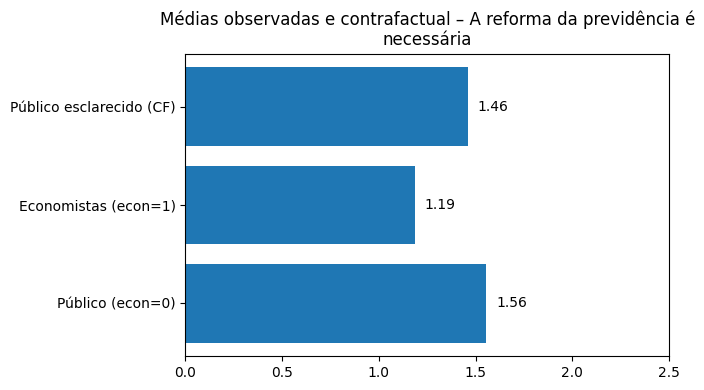

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'reforma_trabalhista_necessária'
INFO:root:Pergunta original: A reforma trabalhista é necessária
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                                   OrderedModel Results                                   
Dep. Variable:     reforma_trabalhista_necessária   Log-Likelihood:                -137.36
Model:                               OrderedModel   AIC:                             316.7
Method:                        Maximum Likelihood   BIC:                             382.5
Date:                            Sat, 16 Aug 2025                                         
Time:                                    22:43:31                                         
No. Observations:                             169                                         
Df Residuals:                                 148                                         
Df Model:                                      19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------

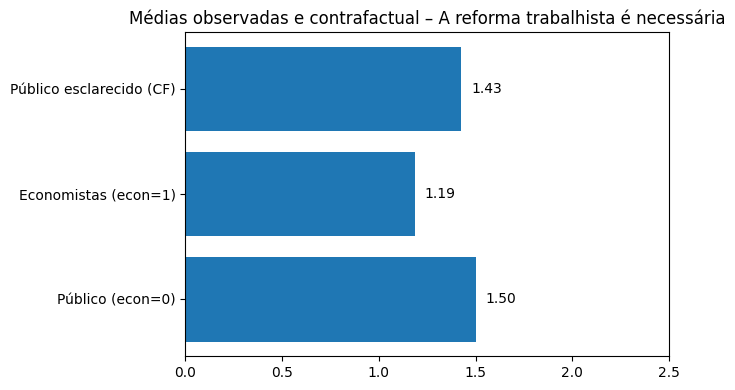

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'reforma_tributária_necessária'
INFO:root:Pergunta original: A reforma tributária é necessária
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                                   OrderedModel Results                                  
Dep. Variable:     reforma_tributária_necessária   Log-Likelihood:                -62.229
Model:                              OrderedModel   AIC:                             166.5
Method:                       Maximum Likelihood   BIC:                             232.2
Date:                           Sat, 16 Aug 2025                                         
Time:                                   22:43:33                                         
No. Observations:                            169                                         
Df Residuals:                                148                                         
Df Model:                                     19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

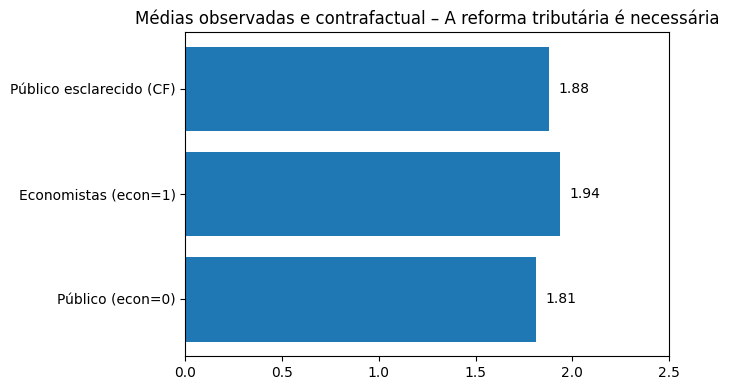

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'privatização_estatais_benéfica'
INFO:root:Pergunta original: A privatização de estatais é benéfica
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                                   OrderedModel Results                                   
Dep. Variable:     privatização_estatais_benéfica   Log-Likelihood:                -147.00
Model:                               OrderedModel   AIC:                             336.0
Method:                        Maximum Likelihood   BIC:                             401.9
Date:                            Sat, 16 Aug 2025                                         
Time:                                    22:43:35                                         
No. Observations:                             170                                         
Df Residuals:                                 149                                         
Df Model:                                      19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------

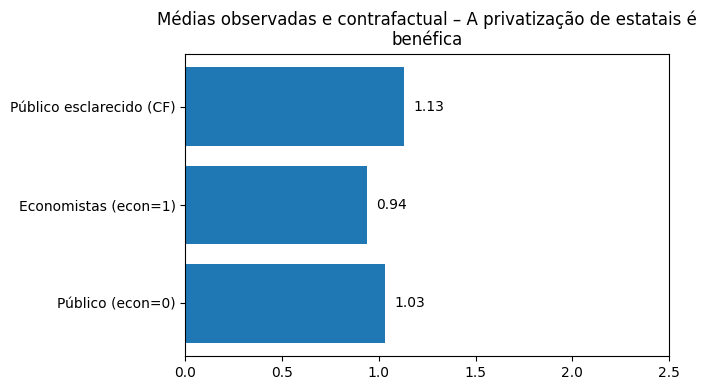

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'produtos_importados_benéficos'
INFO:root:Pergunta original: Produtos importados são benéficos
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                                   OrderedModel Results                                  
Dep. Variable:     produtos_importados_benéficos   Log-Likelihood:                -132.64
Model:                              OrderedModel   AIC:                             307.3
Method:                       Maximum Likelihood   BIC:                             373.0
Date:                           Sat, 16 Aug 2025                                         
Time:                                   22:43:36                                         
No. Observations:                            169                                         
Df Residuals:                                148                                         
Df Model:                                     19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

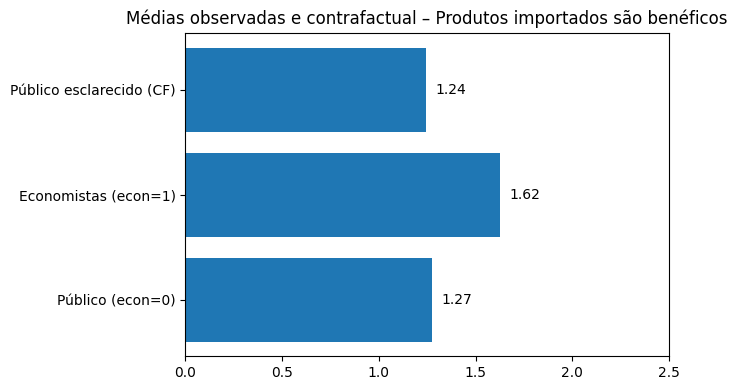

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'corrupção_principal_causa'
INFO:root:Pergunta original: A corrupção é a principal causa do subdesenvolvimento
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                                 OrderedModel Results                                
Dep. Variable:     corrupção_principal_causa   Log-Likelihood:                -136.92
Model:                          OrderedModel   AIC:                             315.8
Method:                   Maximum Likelihood   BIC:                             381.6
Date:                       Sat, 16 Aug 2025                                         
Time:                               22:43:39                                         
No. Observations:                        169                                         
Df Residuals:                            148                                         
Df Model:                                 19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

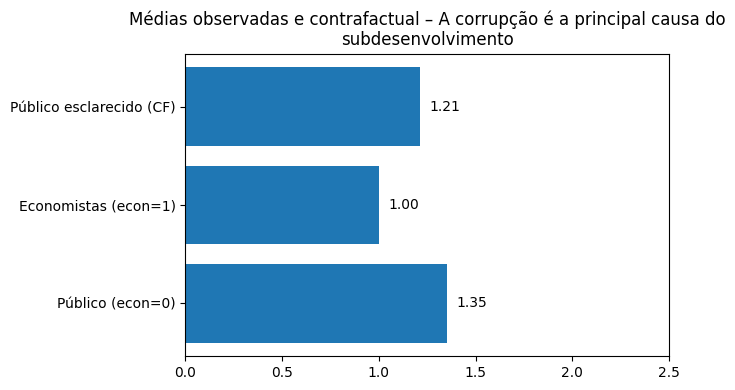

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'taxa_juros_selic'
INFO:root:Pergunta original: A taxa de juros (SELIC) é alta demais
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (168, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    152
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                             OrderedModel Results                             
Dep. Variable:       taxa_juros_selic   Log-Likelihood:                -143.62
Model:                   OrderedModel   AIC:                             329.2
Method:            Maximum Likelihood   BIC:                             394.8
Date:                Sat, 16 Aug 2025                                         
Time:                        22:43:40                                         
No. Observations:                 168                                         
Df Residuals:                     147                                         
Df Model:                          19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Qual é o seu vínculo empregat

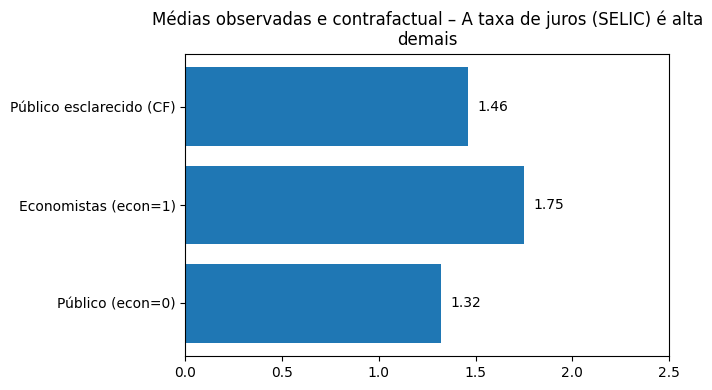

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'governo_atual_sabe'
INFO:root:Pergunta original: O governo atual sabe lidar com crises econômicas
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                             OrderedModel Results                             
Dep. Variable:     governo_atual_sabe   Log-Likelihood:                -107.58
Model:                   OrderedModel   AIC:                             257.2
Method:            Maximum Likelihood   BIC:                             322.9
Date:                Sat, 16 Aug 2025                                         
Time:                        22:43:42                                         
No. Observations:                 169                                         
Df Residuals:                     148                                         
Df Model:                          19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Qual é o seu vínculo empregat

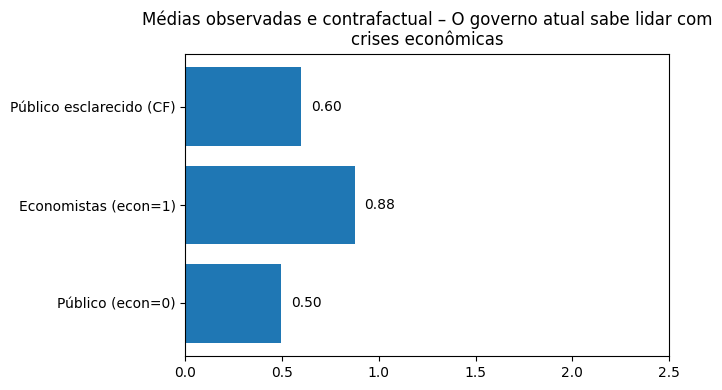

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'governo_deve_intervir'
INFO:root:Pergunta original: O governo deve intervir para controlar preços
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                               OrderedModel Results                              
Dep. Variable:     governo_deve_intervir   Log-Likelihood:                -146.06
Model:                      OrderedModel   AIC:                             334.1
Method:               Maximum Likelihood   BIC:                             399.9
Date:                   Sat, 16 Aug 2025                                         
Time:                           22:43:43                                         
No. Observations:                    169                                         
Df Residuals:                        148                                         
Df Model:                             19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Qu

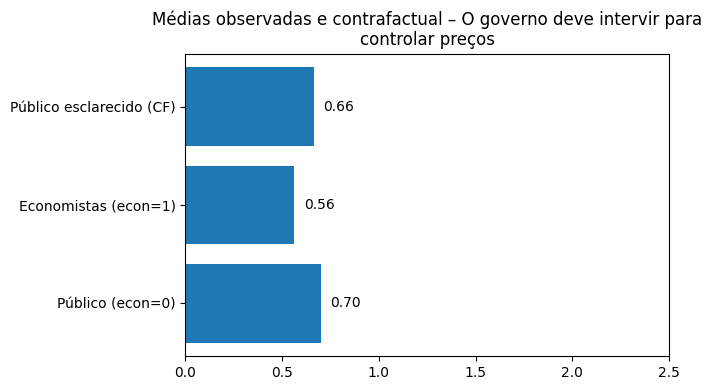

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'entrada_estrangeiros_mercado'
INFO:root:Pergunta original: A entrada de estrangeiros no mercado de trabalho é benéfica
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                                  OrderedModel Results                                  
Dep. Variable:     entrada_estrangeiros_mercado   Log-Likelihood:                -148.94
Model:                             OrderedModel   AIC:                             339.9
Method:                      Maximum Likelihood   BIC:                             405.6
Date:                          Sat, 16 Aug 2025                                         
Time:                                  22:43:44                                         
No. Observations:                           169                                         
Df Residuals:                               148                                         
Df Model:                                    19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

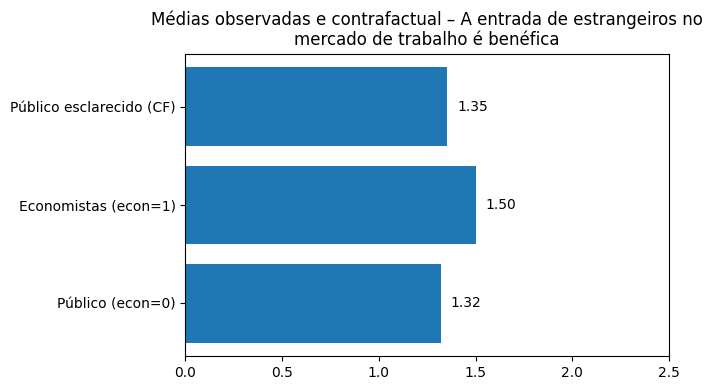

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'indústria_nacional_deve'
INFO:root:Pergunta original: A indústria nacional deve ser protegida
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                                OrderedModel Results                               
Dep. Variable:     indústria_nacional_deve   Log-Likelihood:                -154.54
Model:                        OrderedModel   AIC:                             351.1
Method:                 Maximum Likelihood   BIC:                             416.8
Date:                     Sat, 16 Aug 2025                                         
Time:                             22:43:46                                         
No. Observations:                      169                                         
Df Residuals:                          148                                         
Df Model:                               19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------

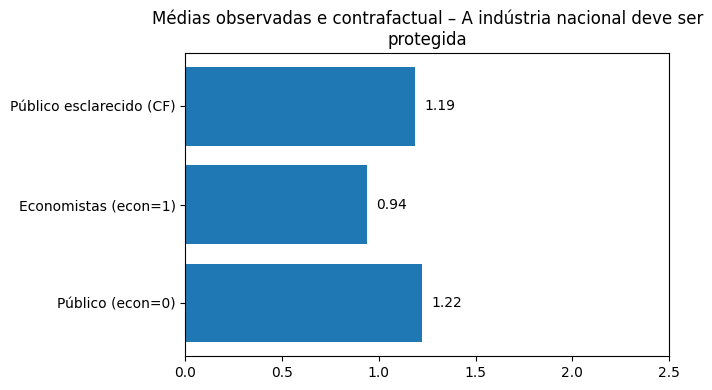

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'brasil_chance_virar'
INFO:root:Pergunta original: O Brasil tem chance de virar potência econômica
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                              OrderedModel Results                             
Dep. Variable:     brasil_chance_virar   Log-Likelihood:                -152.95
Model:                    OrderedModel   AIC:                             347.9
Method:             Maximum Likelihood   BIC:                             413.7
Date:                 Sat, 16 Aug 2025                                         
Time:                         22:43:47                                         
No. Observations:                  170                                         
Df Residuals:                      149                                         
Df Model:                           19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Qual é o seu vínculo

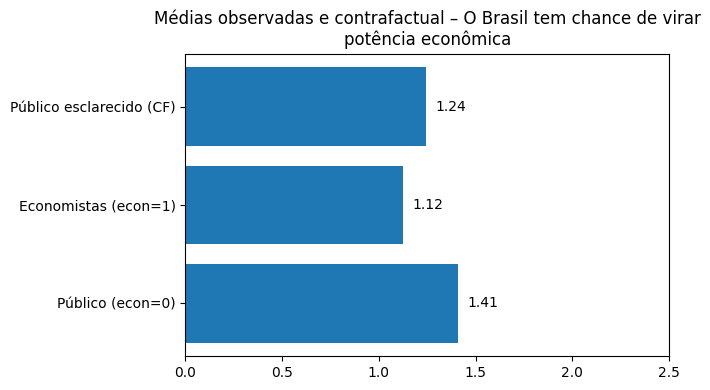

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'lucros_empresariais_ocorrem'
INFO:root:Pergunta original: Lucros empresariais ocorrem às custas dos trabalhadores
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                                  OrderedModel Results                                 
Dep. Variable:     lucros_empresariais_ocorrem   Log-Likelihood:                -149.59
Model:                            OrderedModel   AIC:                             341.2
Method:                     Maximum Likelihood   BIC:                             406.9
Date:                         Sat, 16 Aug 2025                                         
Time:                                 22:43:48                                         
No. Observations:                          169                                         
Df Residuals:                              148                                         
Df Model:                                   19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

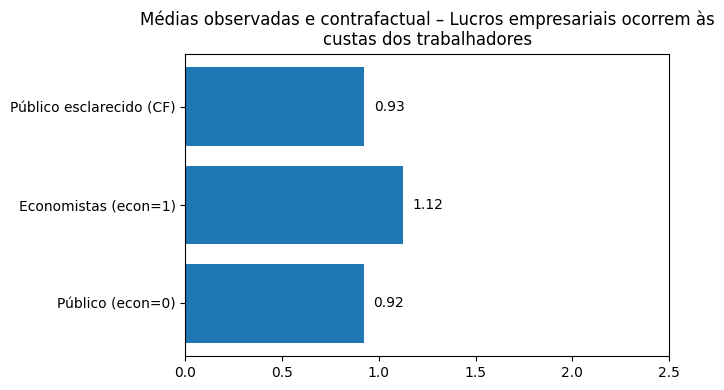

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'competição_entre_empresas'
INFO:root:Pergunta original: A competição entre empresas beneficia consumidores
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                                 OrderedModel Results                                
Dep. Variable:     competição_entre_empresas   Log-Likelihood:                -74.625
Model:                          OrderedModel   AIC:                             191.3
Method:                   Maximum Likelihood   BIC:                             257.0
Date:                       Sat, 16 Aug 2025                                         
Time:                               22:43:50                                         
No. Observations:                        169                                         
Df Residuals:                            148                                         
Df Model:                                 19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

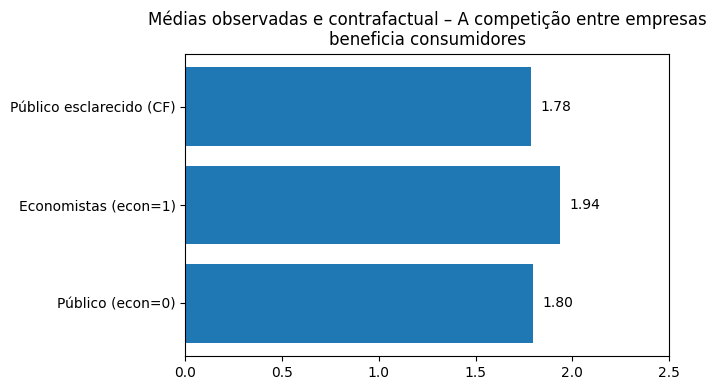

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'brasil_deveria_priorizar'
INFO:root:Pergunta original: O Brasil deveria priorizar a produção interna mesmo com preços maiores
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (168, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    152
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                                OrderedModel Results                                
Dep. Variable:     brasil_deveria_priorizar   Log-Likelihood:                -137.76
Model:                         OrderedModel   AIC:                             317.5
Method:                  Maximum Likelihood   BIC:                             383.1
Date:                      Sat, 16 Aug 2025                                         
Time:                              22:43:52                                         
No. Observations:                       168                                         
Df Residuals:                           147                                         
Df Model:                                19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------

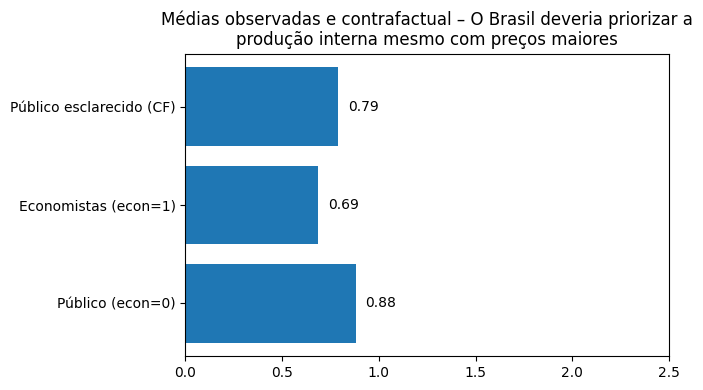

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'automação_prejudica_mercado'
INFO:root:Pergunta original: A automação prejudica o mercado de trabalho
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                                  OrderedModel Results                                 
Dep. Variable:     automação_prejudica_mercado   Log-Likelihood:                -118.12
Model:                            OrderedModel   AIC:                             278.2
Method:                     Maximum Likelihood   BIC:                             344.1
Date:                         Sat, 16 Aug 2025                                         
Time:                                 22:43:53                                         
No. Observations:                          170                                         
Df Residuals:                              149                                         
Df Model:                                   19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

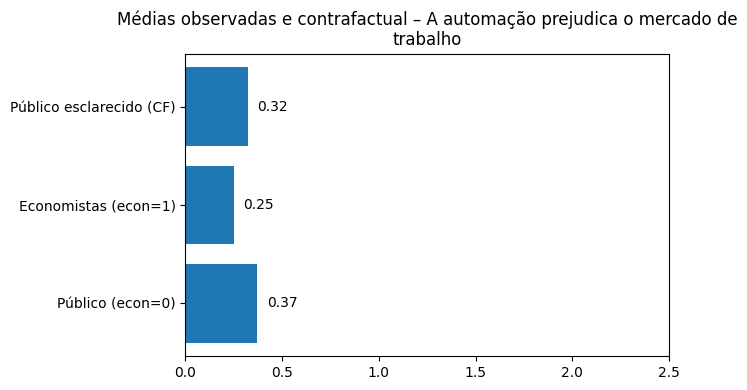

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'brasil_deveria_adotar'
INFO:root:Pergunta original: O Brasil deveria adotar política de livre comércio com outros países
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                               OrderedModel Results                              
Dep. Variable:     brasil_deveria_adotar   Log-Likelihood:                -130.47
Model:                      OrderedModel   AIC:                             302.9
Method:               Maximum Likelihood   BIC:                             368.7
Date:                   Sat, 16 Aug 2025                                         
Time:                           22:43:55                                         
No. Observations:                    169                                         
Df Residuals:                        148                                         
Df Model:                             19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Qu

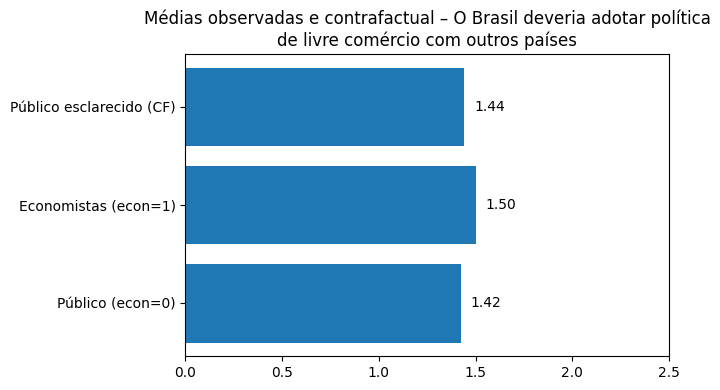

INFO:root:Gráfico exibido com sucesso


In [28]:
import os, logging
import numpy as np
import pandas as pd
import textwrap
import matplotlib.pyplot as plt
from statsmodels.miscmodels.ordinal_model import OrderedModel

logging.basicConfig(level=logging.INFO)

def analisar_variavel_para_latex_log(df_all, variavel, control_cols):
    logging.info(f"Iniciando análise da variável '{variavel}'")
    logging.info(f"Pergunta original: {acronimos.get(variavel)}")

    try:
        # 1) Monta dataset: Y + X e remove NaN
        logging.info("Concatenando variável dependente e controles")
        df_model = pd.concat([df_all[[variavel]], df_all[control_cols]], axis=1).dropna()
        logging.info(f"Shape do df_model: {df_model.shape}")

        # 2) Y ordinal e classes reais (ex.: {0,1,2})
        y = pd.to_numeric(df_model[variavel], errors='coerce').astype(int)
        if y.nunique() < 2:
            logging.warning("Menos de duas classes na variável dependente após limpeza. Pulando.")
            return

        classes = np.sort(y.unique())              # <<< usa rótulos reais (0,1,2 ou 1,2,3 etc.)

        # 3) X numérico
        X = df_model[control_cols].apply(pd.to_numeric, errors='coerce').astype(float)

        # Info de econ
        econ_disponivel = 'econ' in X.columns
        if econ_disponivel:
            vc = X['econ'].value_counts(dropna=False)
            logging.info(f"value_counts econ em df_model:\n{vc}")

        # 4) Remove colunas constantes (incluindo econ se for o caso)
        nunique = X.nunique()
        const_like = nunique[nunique <= 1].index.tolist()
        if const_like:
            logging.info(f"Removendo colunas constantes: {const_like}")
            X = X.drop(columns=const_like)
        econ_disponivel = ('econ' in X.columns)    # reavalia

        # 5) Ajusta OrderedModel (com fallback de solver)
        logging.info("Ajustando modelo OrderedModel")
        model = OrderedModel(y, X, distr='logit', hasconst=False)
        try:
            result = model.fit(method='lbfgs', disp=False)
        except Exception:
            try:
                result = model.fit(method='bfgs', disp=False)
            except Exception:
                result = model.fit(method='powell', disp=False)
        logging.info("Modelo ajustado com sucesso")
        print(result.summary())

        # 6) Médias observadas por grupo
        if econ_disponivel:
            mask_e0 = (X['econ'] == 0)
            mask_e1 = (X['econ'] == 1)
            media_publico_geral_obs = df_model.loc[mask_e0, variavel].mean() if mask_e0.any() else np.nan
            media_economistas_obs   = df_model.loc[mask_e1, variavel].mean() if mask_e1.any() else np.nan
        else:
            media_publico_geral_obs = np.nan
            media_economistas_obs   = np.nan

        # 7) Contrafactual: para econ=1, prever com econ=0 e tirar E[Y|X]
        media_publico_esclarecido = np.nan
        if econ_disponivel and (X['econ'] == 1).any():
            X_cf = X.loc[X['econ'] == 1].copy()
            X_cf['econ'] = 0.0
            probs = result.predict(X_cf)                 # shape (n_obs, J)
            valores = classes.astype(float)              # <<< usa as classes reais
            exp_resp = probs @ valores                   # E[Y|X, econ=0]
            media_publico_esclarecido = float(np.mean(exp_resp))

        # 8) Imprime resumo amigável
        def fmt(x): return f"{x:.3f}" if pd.notna(x) else "n/d"
        print(f"Média observada – Público (econ=0): {fmt(media_publico_geral_obs)}")
        print(f"Média observada – Economistas (econ=1): {fmt(media_economistas_obs)}")
        print(f"Média contrafactual – Públic. esclarecido (econ→0): {fmt(media_publico_esclarecido)}")

        # 9) Gráfico (garante pasta)
        os.makedirs("imagens", exist_ok=True)
        labels = ['Público (econ=0)', 'Economistas (econ=1)', 'Público esclarecido (CF)']
        valores_plot = [
            media_publico_geral_obs if pd.notna(media_publico_geral_obs) else 0.0,
            media_economistas_obs   if pd.notna(media_economistas_obs)   else 0.0,
            media_publico_esclarecido if pd.notna(media_publico_esclarecido) else 0.0
        ]
        plt.figure(figsize=(7, 4))
        plt.barh(labels, valores_plot)
        titulo = f"Médias observadas e contrafactual – {acronimos.get(variavel, variavel)}"
        plt.title(textwrap.fill(titulo, width=70))
        max_x = max([v for v in valores_plot if not np.isnan(v)] + [classes.max()])
        plt.xlim(classes.min(), max(classes.max(), max_x + 0.5))
        for i, v in enumerate(valores_plot):
            plt.text(v + 0.05, i, f'{v:.2f}', va='center')
        plt.xlabel('')
        plt.ylabel('')
        plt.tight_layout()
        plt.savefig(f'imagens/{variavel}.png', bbox_inches='tight')
        plt.show()
        logging.info("Gráfico exibido com sucesso")

    except Exception as e:
        logging.error(f"Erro durante a análise: {e}", exc_info=True)
        

# --- 5) Loop pelas dependentes ---
for variavel in dependentes_cols:
    analisar_variavel_para_latex_log(df_final, variavel, df_controle_dummies.columns.tolist())


INFO:root:Iniciando análise da variável 'produtividade_está_aumentando'
INFO:root:Pergunta original: A produtividade está aumentando devagar demais
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


                                   OrderedModel Results                                  
Dep. Variable:     produtividade_está_aumentando   Log-Likelihood:                -158.25
Model:                              OrderedModel   AIC:                             358.5
Method:                       Maximum Likelihood   BIC:                             424.3
Date:                           Sat, 16 Aug 2025                                         
Time:                                   22:24:57                                         
No. Observations:                            170                                         
Df Residuals:                                149                                         
Df Model:                                     19                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

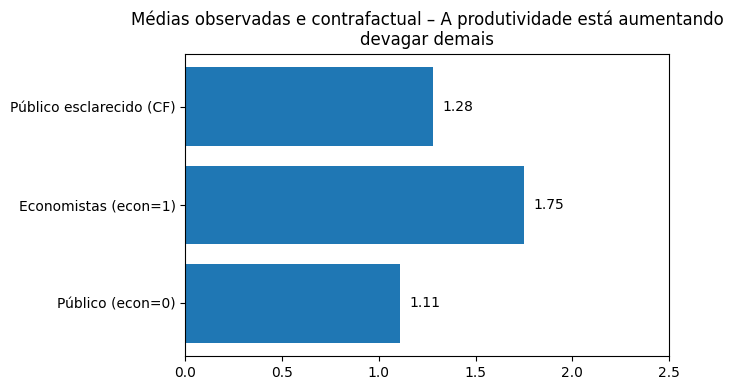

INFO:root:Gráfico exibido com sucesso


In [27]:
analises = [
    # "déficit_federal_grande",
    # "gasto_ajuda_externa",
    "produtividade_está_aumentando"
]

# vamos rodar as análises para esses três itens e colocar nos gráficos os titulos das perguntas

for analise in analises:
    # aqui você rodaria a análise para cada item
    # e colocaria os títulos das perguntas nos gráficos
    analisar_variavel_para_latex_log(df_final, analise, df_controle_dummies.columns.tolist())

INFO:root:Iniciando análise da variável 'impostos_muito_altos'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


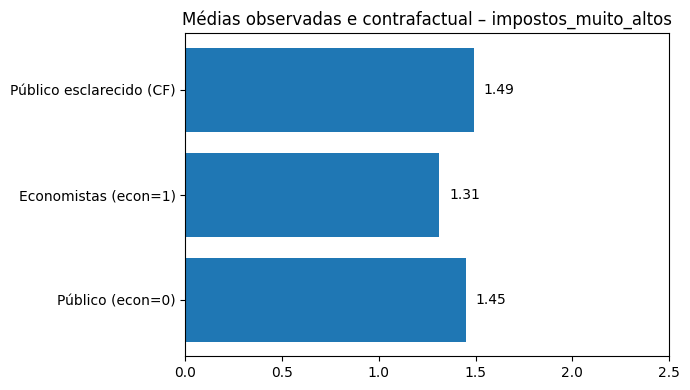

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'déficit_federal_grande'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


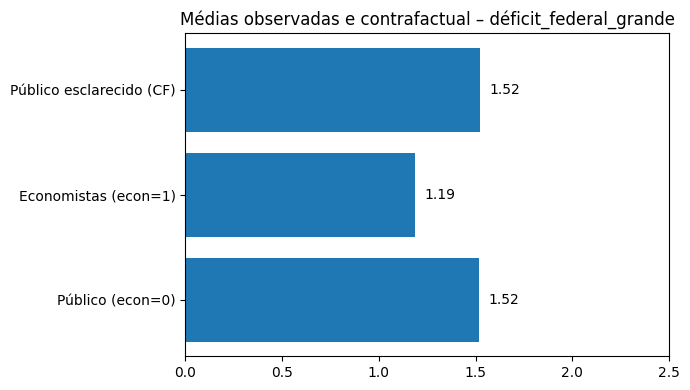

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'gasto_ajuda_externa'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


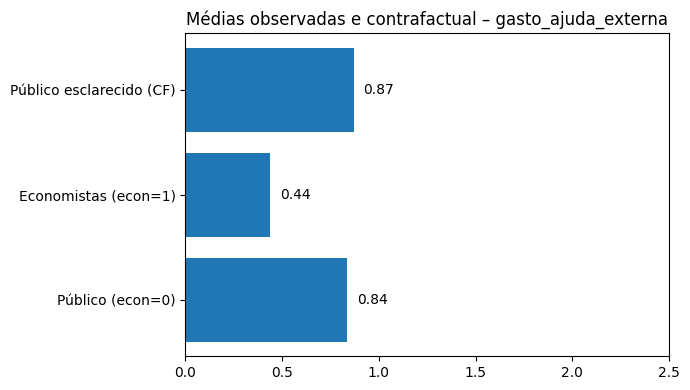

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'temos_imigrantes_demais'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


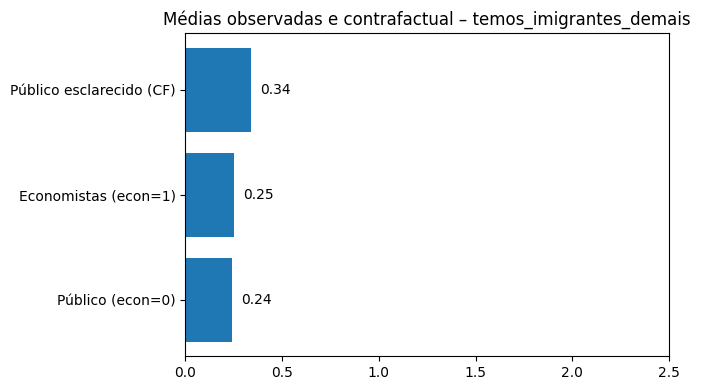

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'há_deduções_demais'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (171, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    155
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


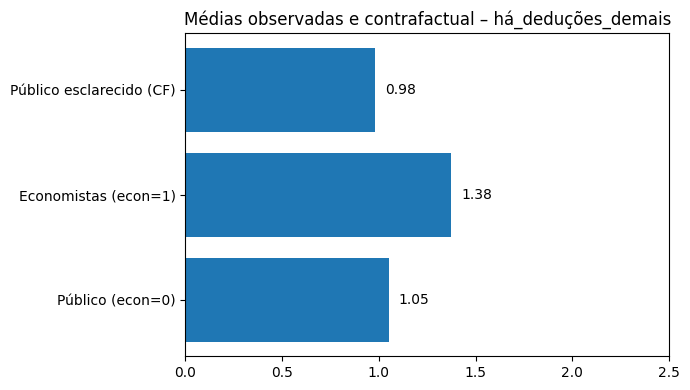

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'educação_qualificação_profissional'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


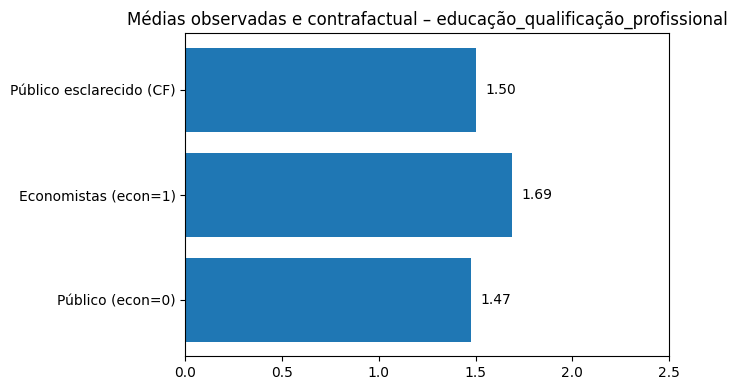

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'seguridade_social_previdência'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (171, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    155
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


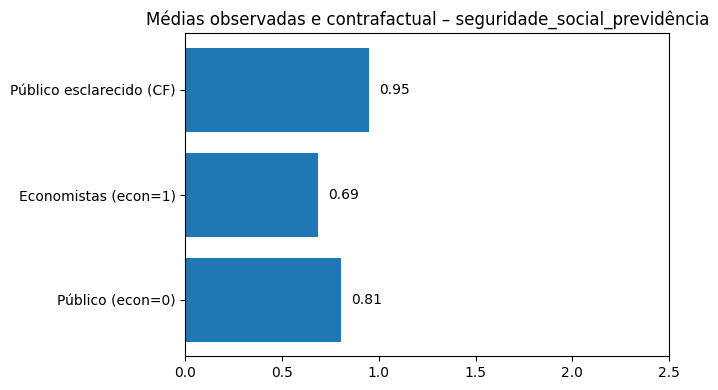

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'mulheres_minorias_têm'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


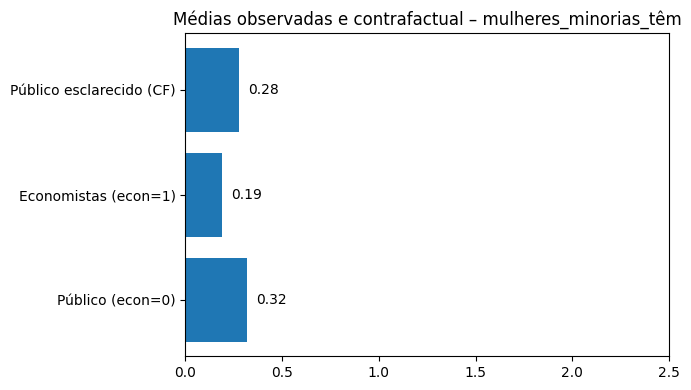

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'pessoas_não_dão'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (171, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    155
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


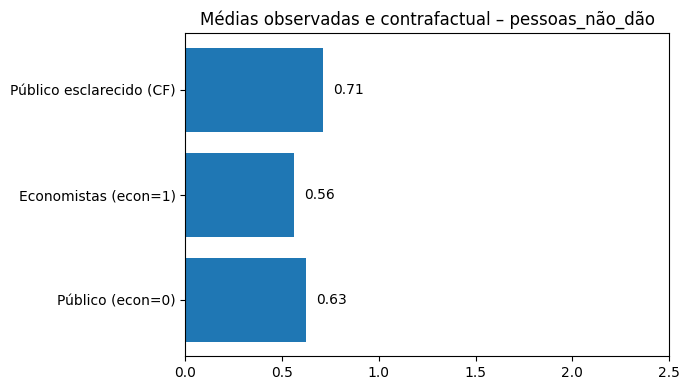

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'governo_regulamenta_muito'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (171, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    155
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


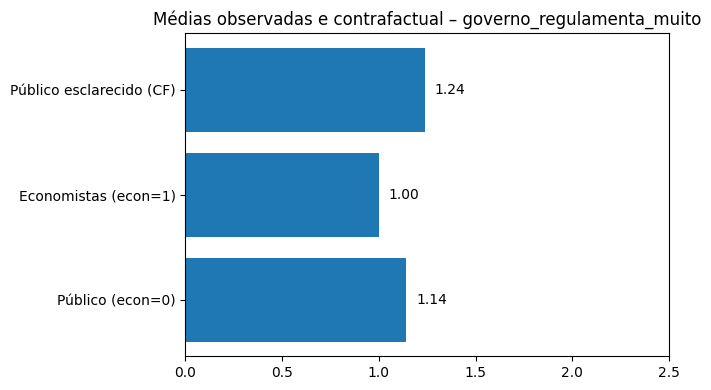

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'pessoas_não_poupam'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (171, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    155
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


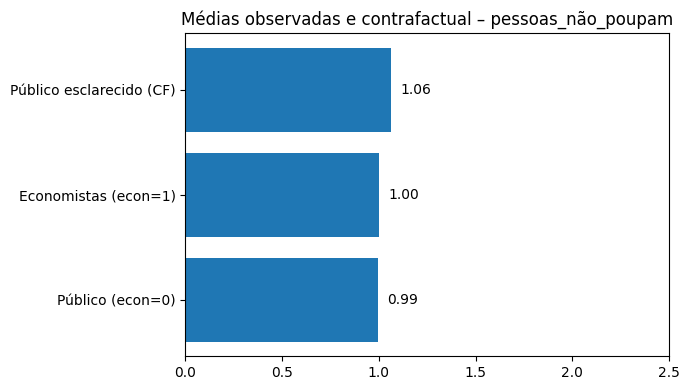

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'empresas_lucram_demais'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


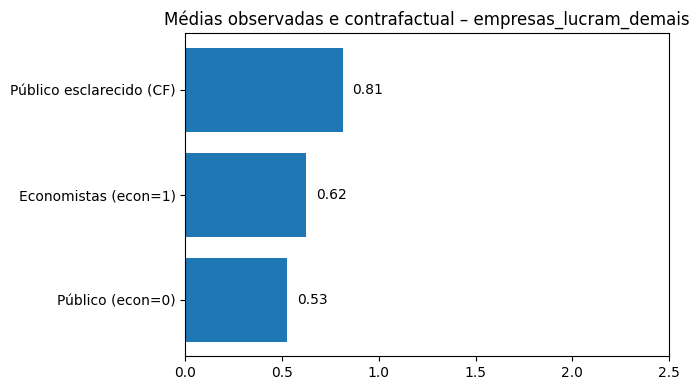

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'altos_executivos_ganham'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


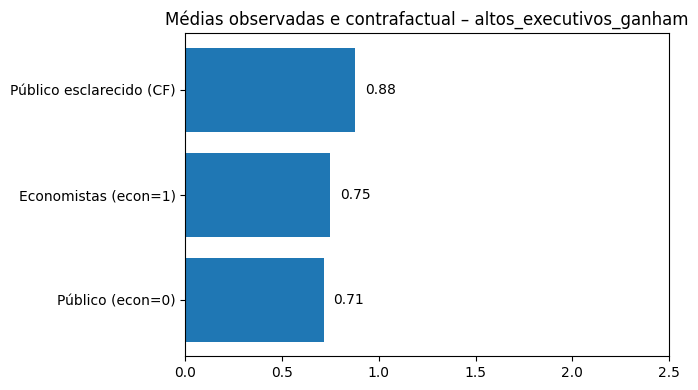

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'produtividade_está_aumentando'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


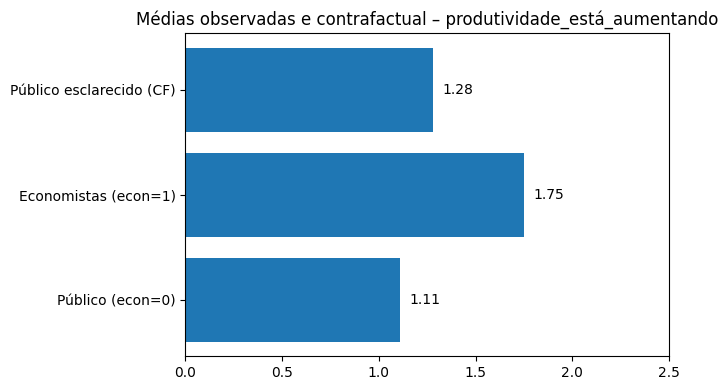

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'tecnologia_causa_demissões'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


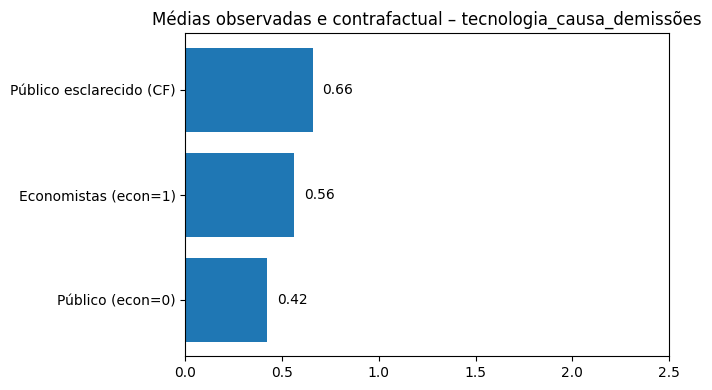

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'empresas_estão_enviando'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (171, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    155
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


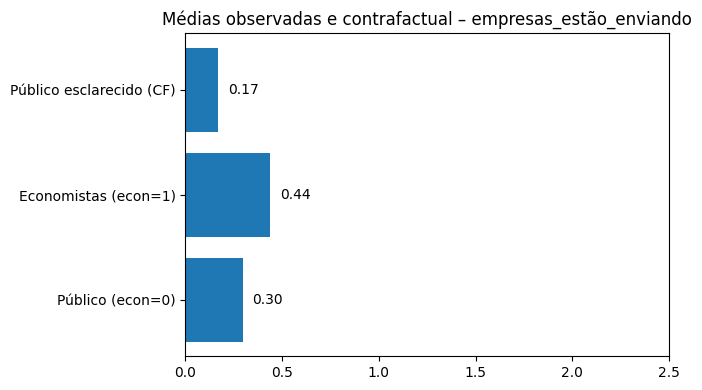

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'empresas_estão_reduzindo'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (171, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    155
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


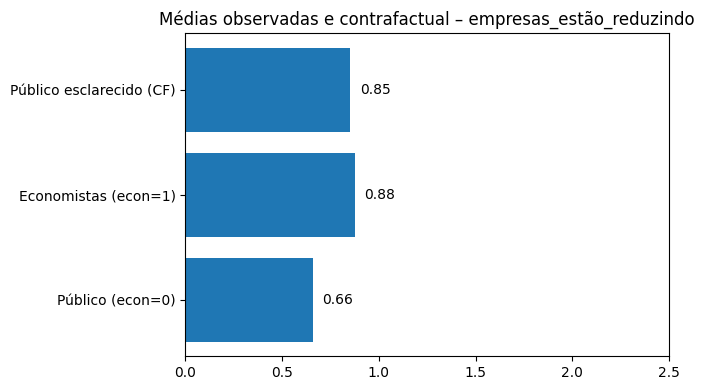

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'empresas_não_investem'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


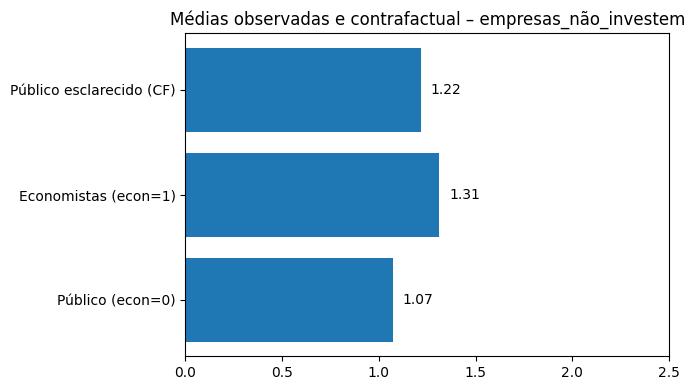

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'corte_impostos'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (171, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    155
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


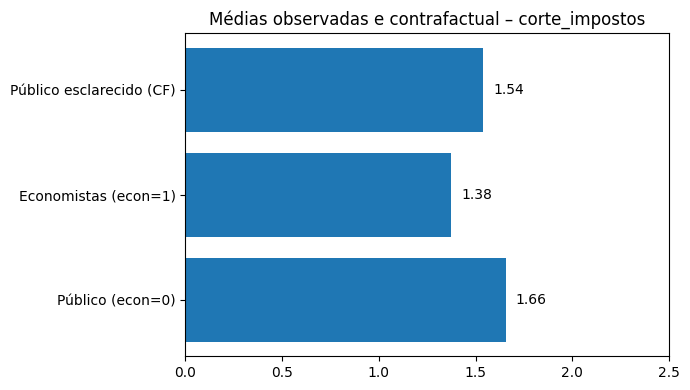

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'mais_mulheres_força'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (171, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    155
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


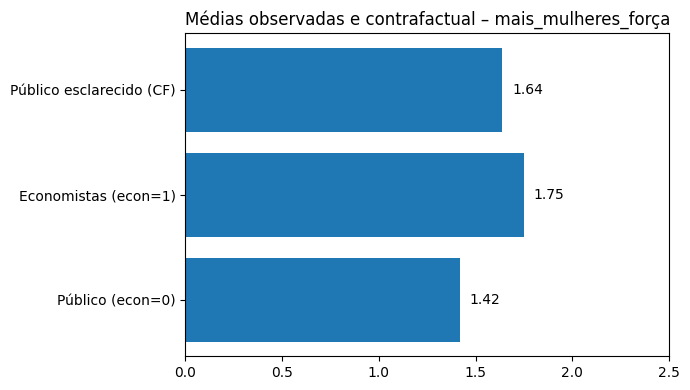

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'aumento_uso_tecnologia'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (171, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    155
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
/home/schadenlord/ubuntu/udesc/tcc_esag/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
INFO:root:Modelo ajustado com sucesso


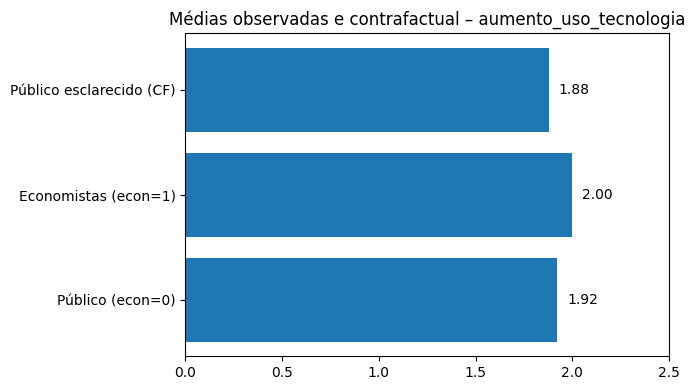

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'acordos_comerciais_outros'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (171, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    155
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
/home/schadenlord/ubuntu/udesc/tcc_esag/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
INFO:root:Modelo ajustado com sucesso


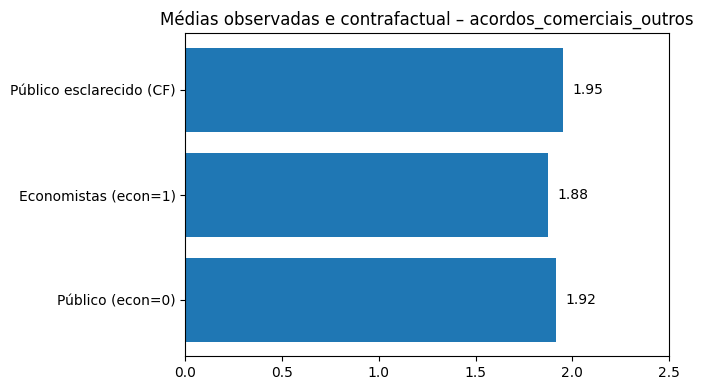

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'redução_recente_postos'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


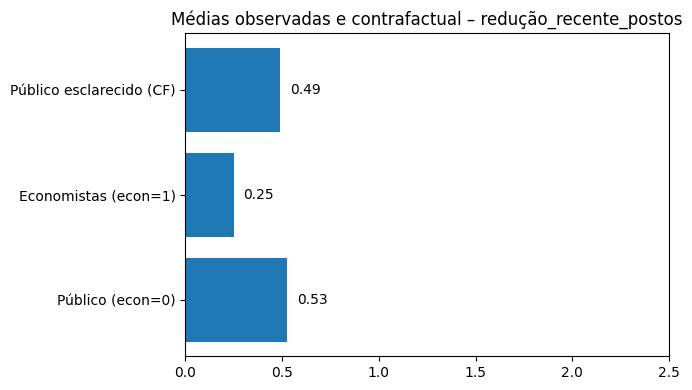

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'algumas_pessoas_dizem'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 21)
ERROR:root:Erro durante a análise: arg must be a list, tuple, 1-d array, or Series
Traceback (most recent call last):
  File "/tmp/ipykernel_1815/873264162.py", line 21, in analisar_variavel_para_latex_log
    y = pd.to_numeric(df_model[variavel], errors='coerce').astype(int)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/schadenlord/ubuntu/udesc/tcc_esag/.venv/lib/python3.12/site-packages/pandas/core/tools/numeric.py", line 209, in to_numeric
    raise TypeError("arg must be a list, tuple, 1-d array, or Series")
TypeError: arg must be a list, tuple, 1-d array, or Series
INFO:root:Iniciando análise da variável 'acha_acordos_comerciais'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:S

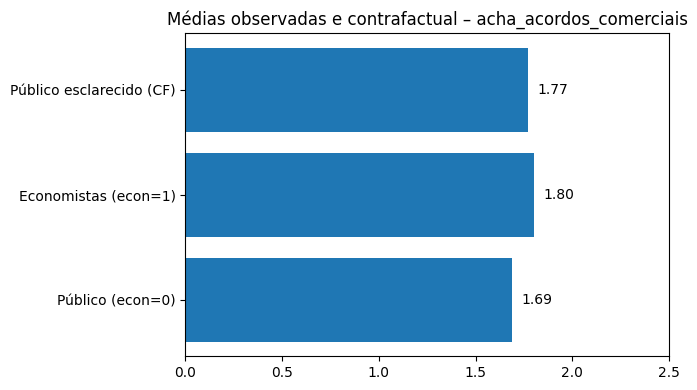

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'quem_considera_maior'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


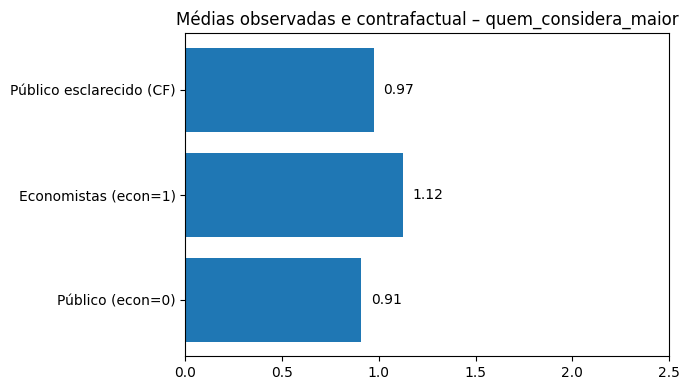

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'acha_preços_combustíveis'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (171, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    155
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
/home/schadenlord/ubuntu/udesc/tcc_esag/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
INFO:root:Modelo ajustado com sucesso


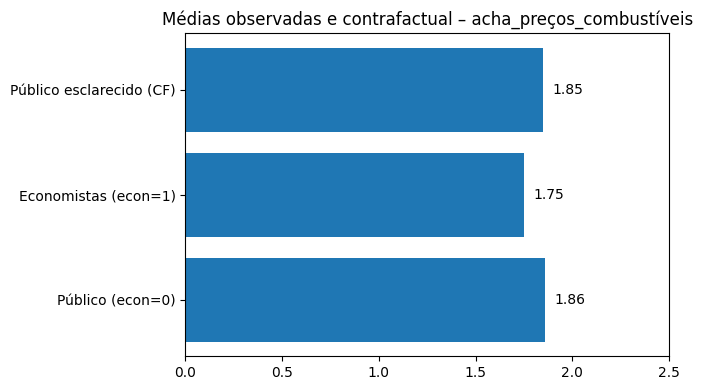

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'acha_presidente_pode'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (167, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    152
1.0     15
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


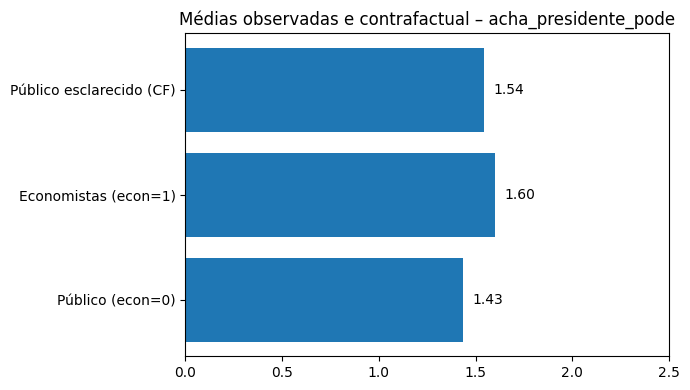

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'acha_novos_postos'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (168, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    152
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


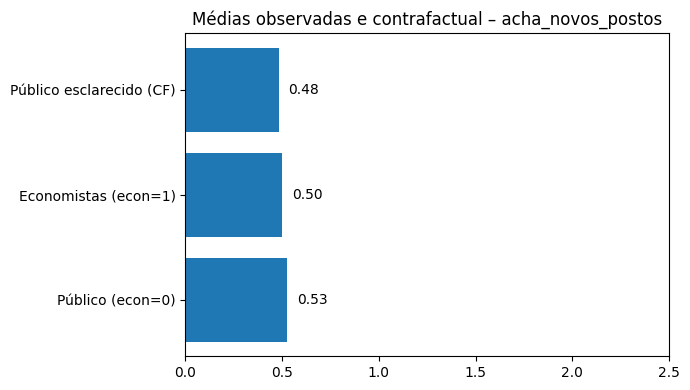

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'desigualdade_entre_ricos'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


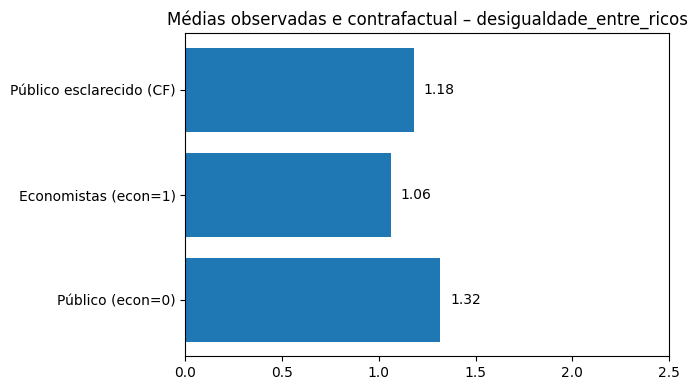

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'últimos_20_anos'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


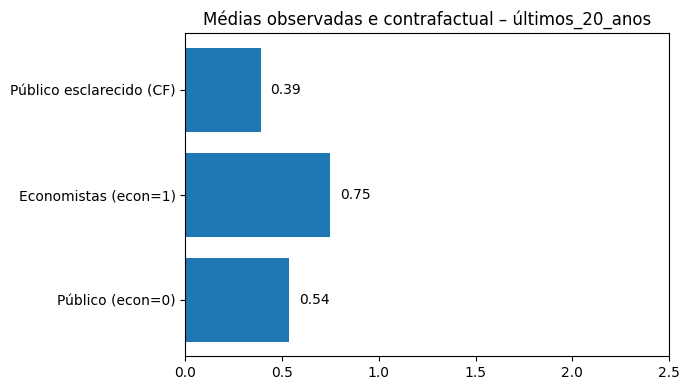

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'pensando_apenas_salários'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (168, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    152
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
/home/schadenlord/ubuntu/udesc/tcc_esag/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
INFO:root:Modelo ajustado com sucesso


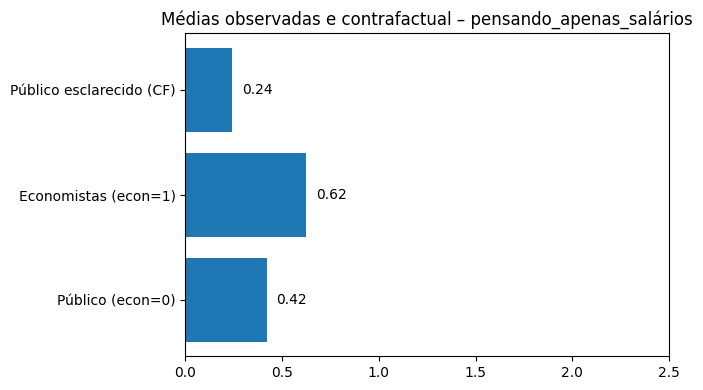

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'algumas_pessoas_dizem'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 21)
ERROR:root:Erro durante a análise: arg must be a list, tuple, 1-d array, or Series
Traceback (most recent call last):
  File "/tmp/ipykernel_1815/873264162.py", line 21, in analisar_variavel_para_latex_log
    y = pd.to_numeric(df_model[variavel], errors='coerce').astype(int)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/schadenlord/ubuntu/udesc/tcc_esag/.venv/lib/python3.12/site-packages/pandas/core/tools/numeric.py", line 209, in to_numeric
    raise TypeError("arg must be a list, tuple, 1-d array, or Series")
TypeError: arg must be a list, tuple, 1-d array, or Series
INFO:root:Iniciando análise da variável 'próximos_cinco_anos'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape

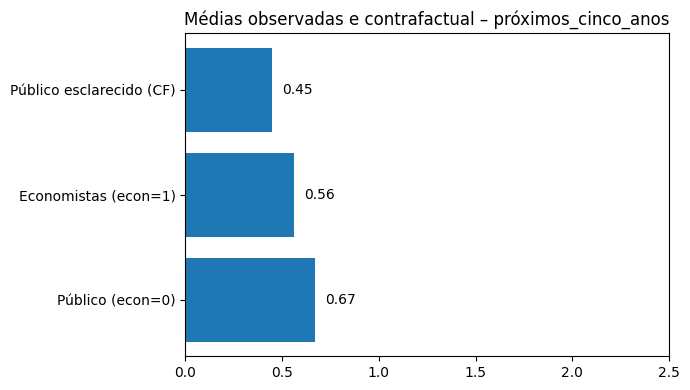

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'espera_geração_seus'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


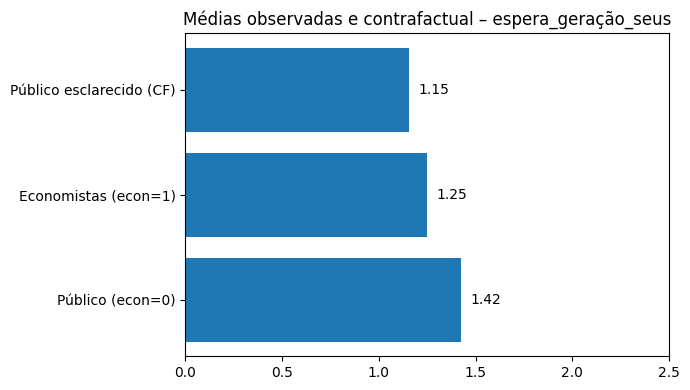

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'filhos_menos_30'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (128, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    114
1.0     14
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
/home/schadenlord/ubuntu/udesc/tcc_esag/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
INFO:root:Modelo ajustado com sucesso


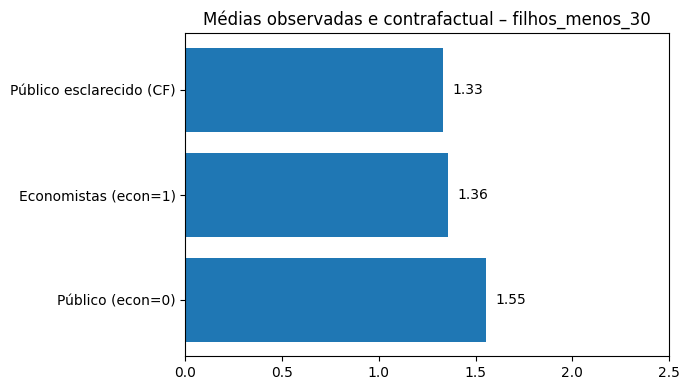

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'reforma_previdência_necessária'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


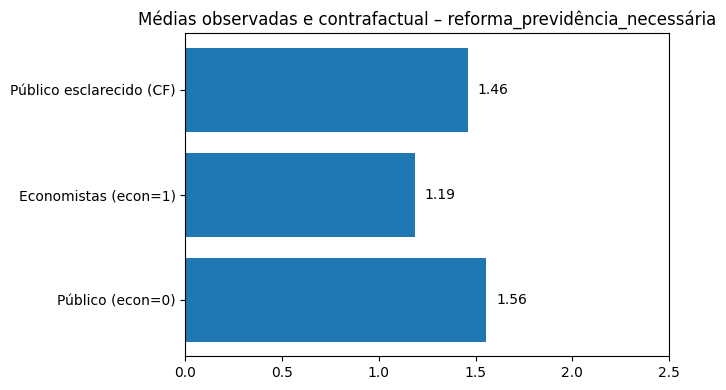

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'reforma_trabalhista_necessária'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


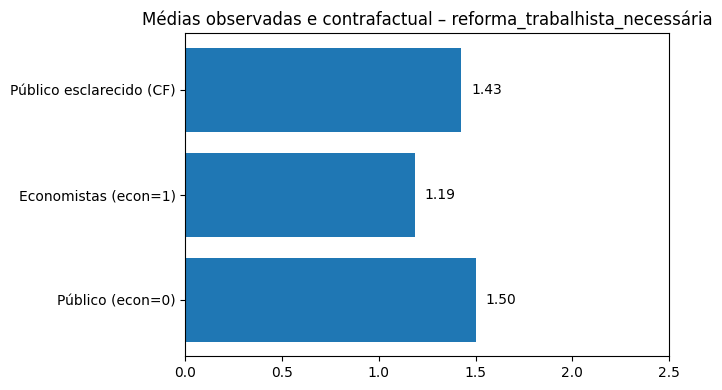

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'reforma_tributária_necessária'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


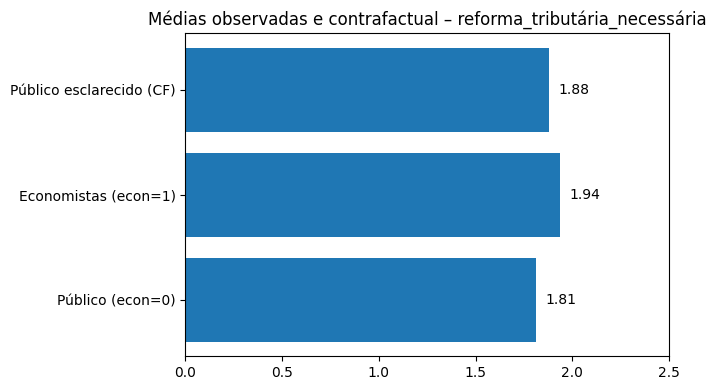

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'privatização_estatais_benéfica'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


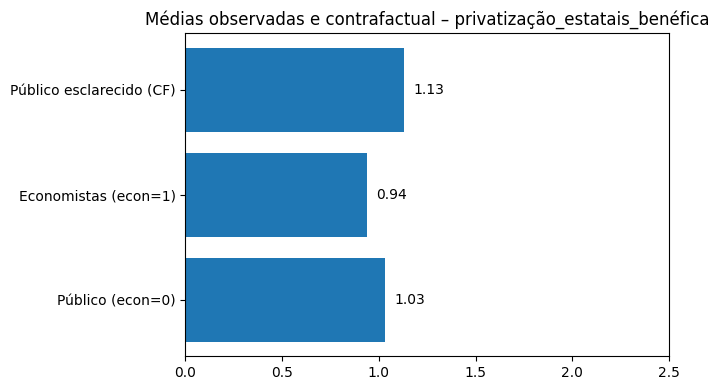

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'produtos_importados_benéficos'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


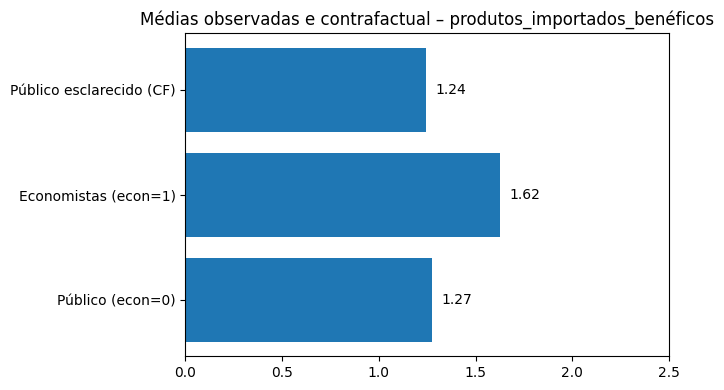

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'corrupção_principal_causa'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


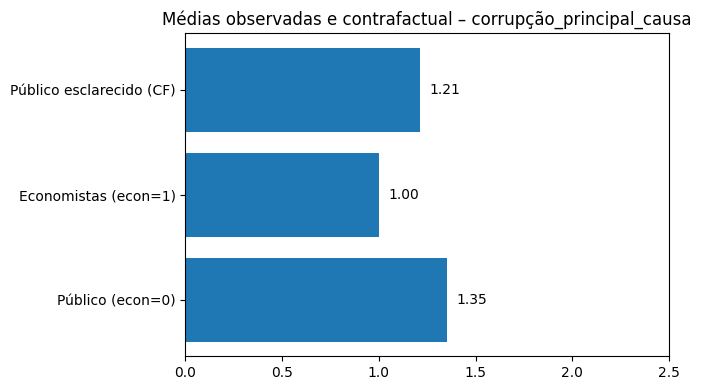

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'taxa_juros_selic'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (168, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    152
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


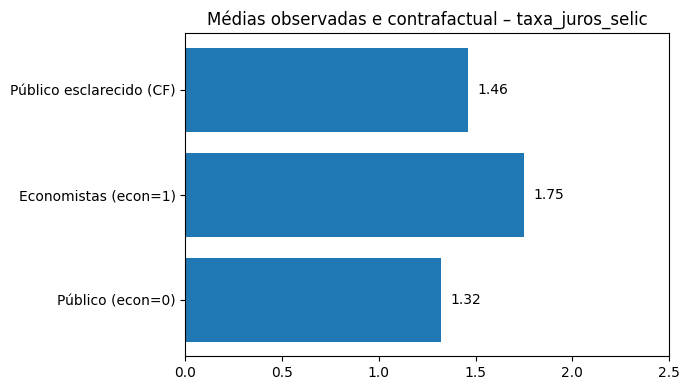

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'governo_atual_sabe'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


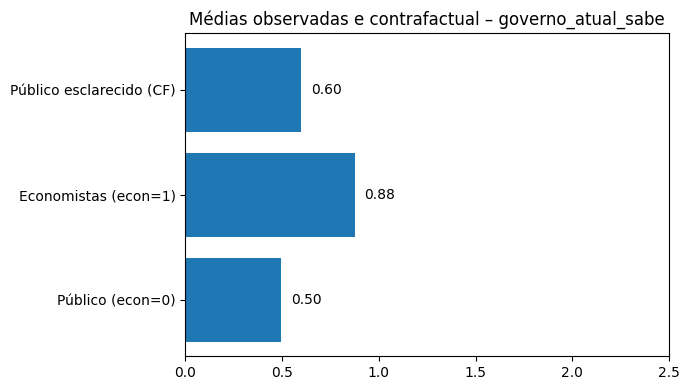

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'governo_deve_intervir'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


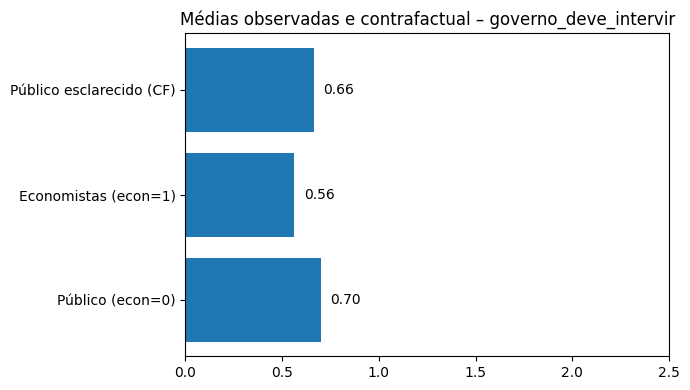

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'entrada_estrangeiros_mercado'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


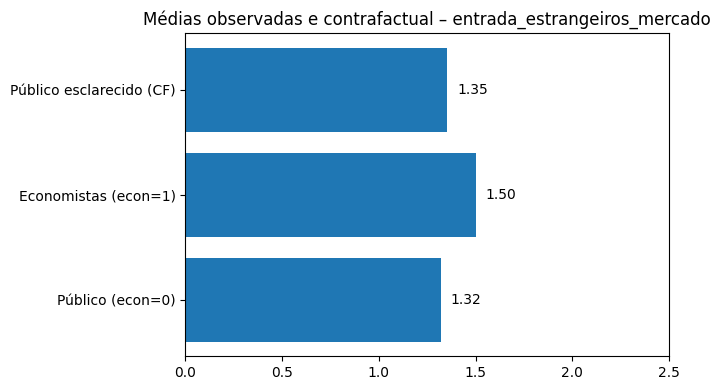

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'indústria_nacional_deve'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


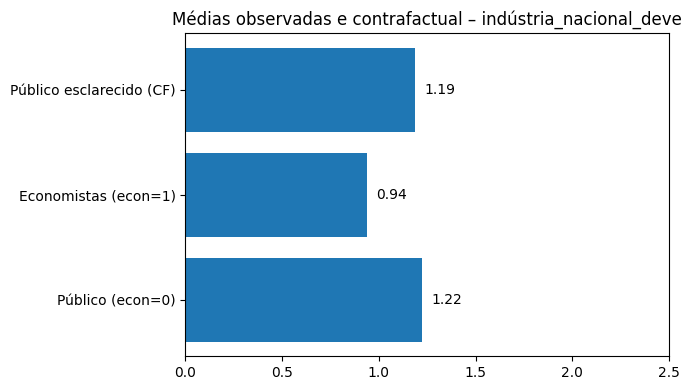

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'brasil_chance_virar'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


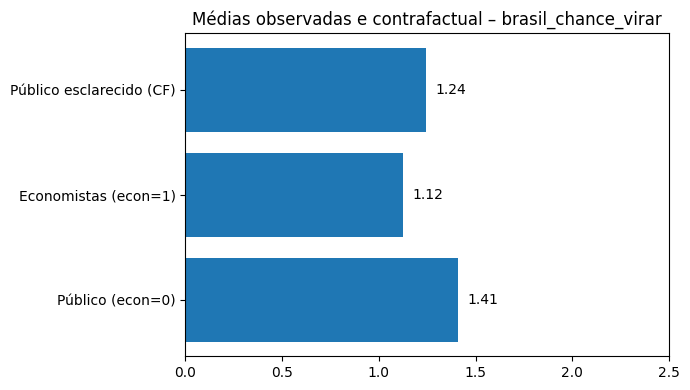

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'lucros_empresariais_ocorrem'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


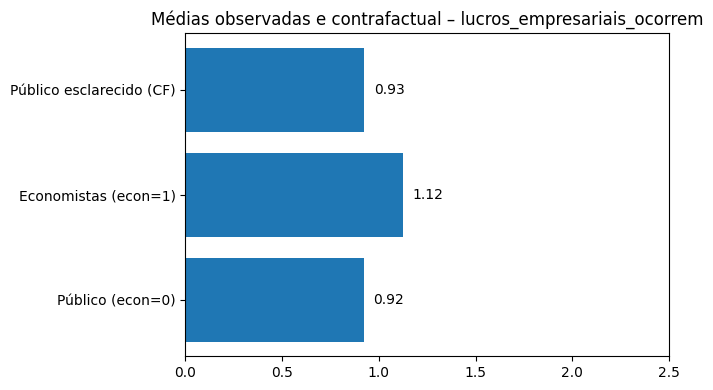

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'competição_entre_empresas'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


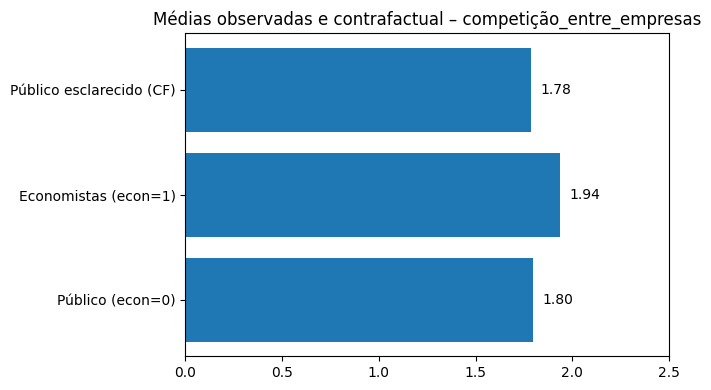

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'brasil_deveria_priorizar'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (168, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    152
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


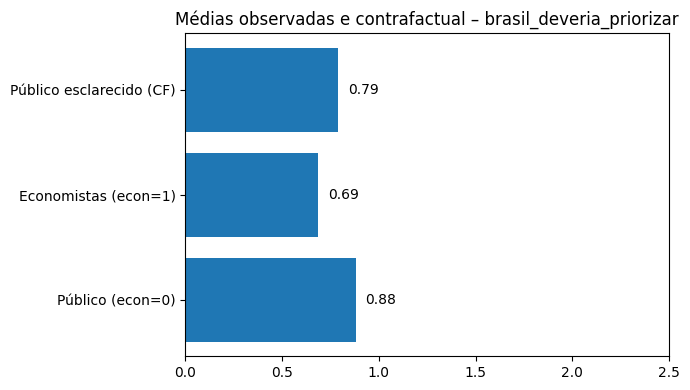

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'automação_prejudica_mercado'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (170, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    154
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


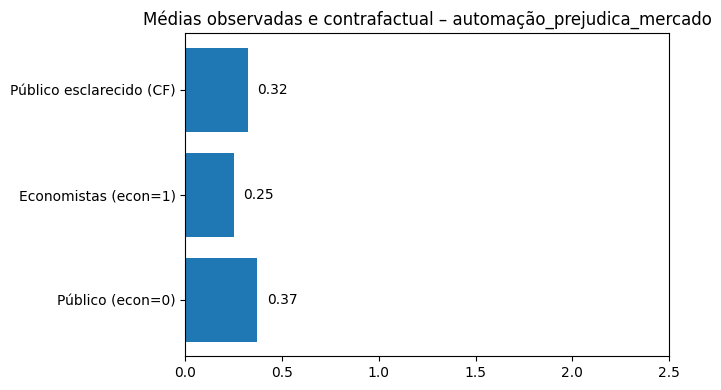

INFO:root:Gráfico exibido com sucesso
INFO:root:Iniciando análise da variável 'brasil_deveria_adotar'
INFO:root:Pergunta original: None
INFO:root:Concatenando variável dependente e controles
INFO:root:Shape do df_model: (169, 20)
INFO:root:value_counts econ em df_model:
econ
0.0    153
1.0     16
Name: count, dtype: int64
INFO:root:Ajustando modelo OrderedModel
INFO:root:Modelo ajustado com sucesso


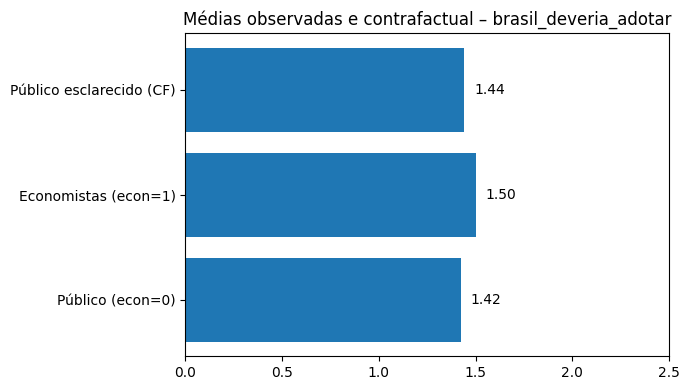

INFO:root:Gráfico exibido com sucesso


In [29]:
from contextlib import redirect_stdout

# colocando todas as saídas dentro de um bloco de notas com a função analisar_variavel_para_latex_log

with open("analises_ordinais.txt", "w", encoding="utf-8") as f:
    with redirect_stdout(f):
        for variavel in dependentes_cols:
            analisar_variavel_para_latex_log(df_final, variavel, df_controle_dummies.columns.tolist())


## 7. Executando análises para todas as variáveis dependentes